In [ ]:
import pyarrow
import pandas as pd
import json

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim.corpora import Dictionary

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud

In [4]:
with open('yelp_academic_dataset_review.json', 'r', encoding='utf-8') as f:
    data = []
    for line in f:
        data.append(json.loads(line))

In [5]:
df = pd.DataFrame(data)
df

review_id                 user_id  \
0        KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA   
1        BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q   
2        saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A   
3        AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ   
4        Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ   
...                         ...                     ...   
6990275  H0RIamZu0B0Ei0P4aeh3sQ  qskILQ3k0I_qcCMI-k6_QQ   
6990276  shTPgbgdwTHSuU67mGCmZQ  Zo0th2m8Ez4gLSbHftiQvg   
6990277  YNfNhgZlaaCO5Q_YJR4rEw  mm6E4FbCMwJmb7kPDZ5v2Q   
6990278  i-I4ZOhoX70Nw5H0FwrQUA  YwAMC-jvZ1fvEUum6QkEkw   
6990279  RwcKOdEuLRHNJe4M9-qpqg  6JehEvdoCvZPJ_XIxnzIIw   

                    business_id  stars  useful  funny  cool  \
0        XQfwVwDr-v0ZS3_CbbE5Xw    3.0       0      0     0   
1        7ATYjTIgM3jUlt4UM3IypQ    5.0       1      0     1   
2        YjUWPpI6HXG530lwP-fb2A    3.0       0      0     0   
3        kxX2SOes4o-D3ZQBkiMRfA    5.0       1      0     1   
4        e4Vwtrqf-wpJfwesgvdgxQ    4.0       1      0     1   
...                         ...    ...     ...    ...   ...   
6990275  jals67o91gcrD4DC81Vk6w    5.0       1      2     1   
6990276  2vLksaMmSEcGbjI5gywpZA    5.0       2      1     2   
6990277  R1khUUxidqfaJmcpmGd4aw    4.0       1      0     0   
6990278  Rr9kKArrMhSLVE9a53q-aA    5.0       1      0     0   
6990279  VAeEXLbEcI9Emt9KGYq9aA    3.0      10      3     7   

                                                      text  \
0        If you decide to eat here, just be aware it is...   
1        I've taken a lot of spin classes over the year...   
2        Family diner. Had the buffet. Eclectic assortm...   
3        Wow!  Yummy, different,  delicious.   Our favo...   
4        Cute interior and owner (?) gave us tour of up...   
...                                                    ...   
6990275  Latest addition to services from ICCU is Apple...   
6990276  This spot offers a great, affordable east week...   
6990277  This Home Depot won me over when I needed to g...   
6990278  For when I'm feeling like ignoring my calorie-...   
6990279  Located in the 'Walking District' in Nashville...   

                        date  
0        2018-07-07 22:09:11  
1        2012-01-03 15:28:18  
2        2014-02-05 20:30:30  
3        2015-01-04 00:01:03  
4        2017-01-14 20:54:15  
...                      ...  
6990275  2014-12-17 21:45:20  
6990276  2021-03-31 16:55:10  
6990277  2019-12-30 03:56:30  
6990278  2022-01-19 18:59:27  
6990279  2018-01-02 22:50:47  

[6990280 rows x 9 columns]

#

In [ ]:
print(f"Dataset shape: {df.shape}")
print(f"Total number of reviews: {len(df)}")

Dataset shape: (6990280, 9)
Total number of reviews: 6990280


In [ ]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   useful       int64  
 5   funny        int64  
 6   cool         int64  
 7   text         object 
 8   date         object 
dtypes: float64(1), int64(3), object(5)
memory usage: 480.0+ MB


In [ ]:

df['date'] = pd.to_datetime(df['date'])

#

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

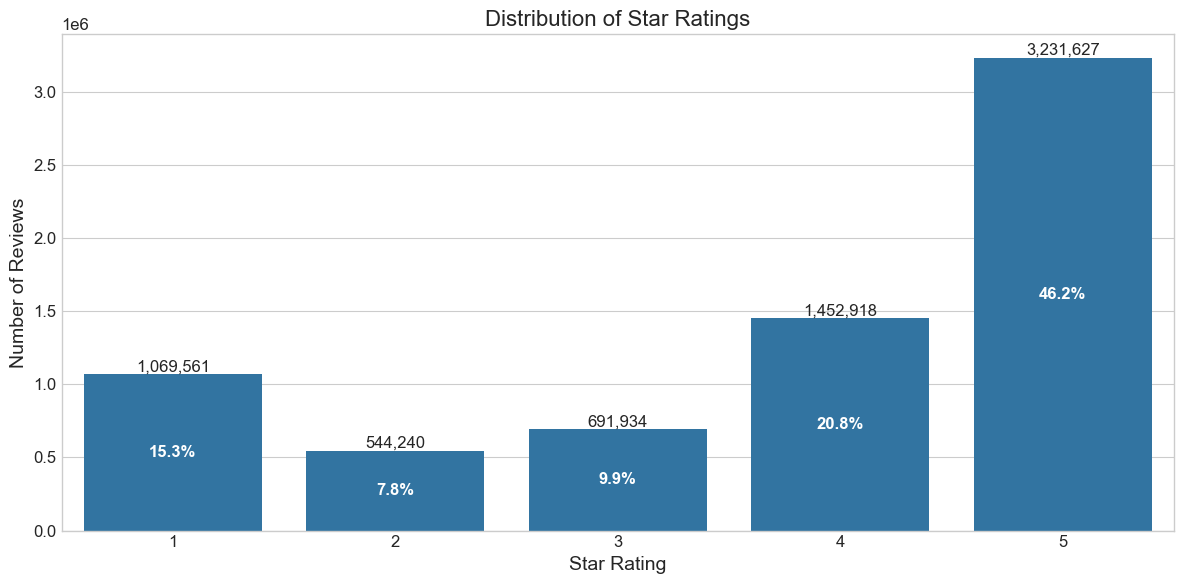

Average rating: 3.75
Median rating: 4.00
Mode rating: 5.00
Median rating: 4.00
Mode rating: 5.00


In [ ]:
plt.figure(figsize=(12, 6))


rating_counts = df['stars'].value_counts().sort_index()


ax = sns.barplot(x=rating_counts.index, y=rating_counts.values)


for i, count in enumerate(rating_counts.values):
    ax.annotate(f'{count:,}', xy=(i, count), ha='center', va='bottom')


total_reviews = len(df)
percentages = [(count/total_reviews)*100 for count in rating_counts.values]


for i, percentage in enumerate(percentages):
    ax.annotate(f'{percentage:.1f}%', xy=(i, rating_counts.values[i]/2), ha='center', va='center', color='white', fontweight='bold')

plt.title('Distribution of Star Ratings', fontsize=16)
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(ticks=range(5), labels=['1', '2', '3', '4', '5'])
plt.tight_layout()
plt.show()


print(f"Average rating: {df['stars'].mean():.2f}")
print(f"Median rating: {df['stars'].median():.2f}")
print(f"Mode rating: {df['stars'].mode()[0]:.2f}")

#

In [ ]:
df['text_length'] = df['text'].apply(len)

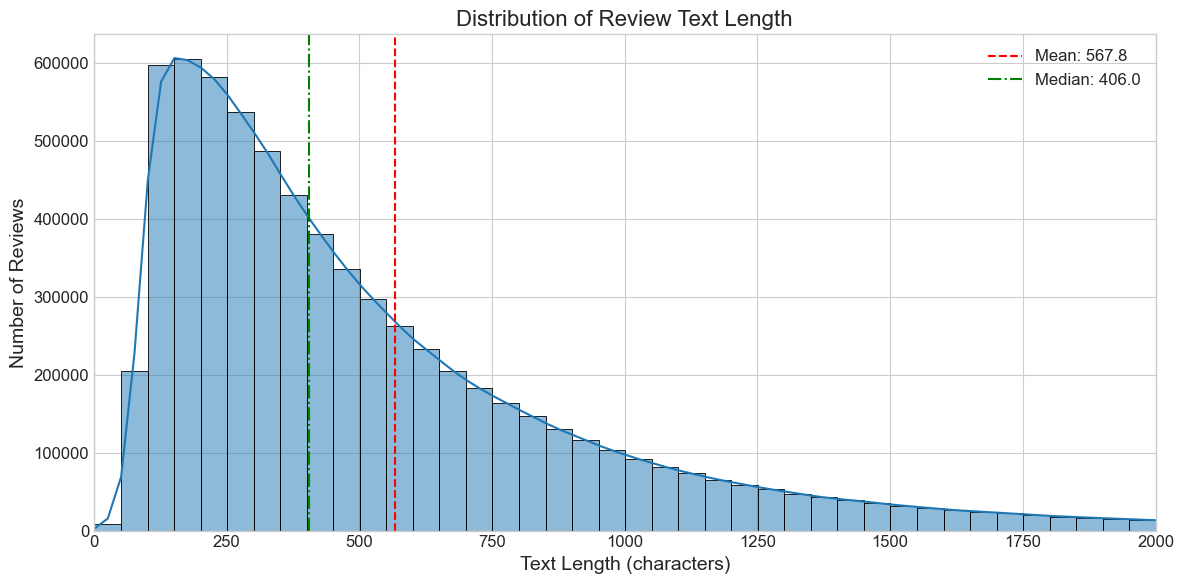

Average review length: 567.76 characters
Median review length: 406.00 characters
Shortest review: 1 characters
Longest review: 5000 characters
Median review length: 406.00 characters
Shortest review: 1 characters
Longest review: 5000 characters


In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], kde=True, bins=100)
plt.title('Distribution of Review Text Length', fontsize=16)
plt.xlabel('Text Length (characters)', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xlim(0, 2000)  
plt.axvline(x=df['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["text_length"].mean():.1f}')
plt.axvline(x=df['text_length'].median(), color='green', linestyle='-.', label=f'Median: {df["text_length"].median():.1f}')
plt.legend()
plt.tight_layout()
plt.show()


print(f"Average review length: {df['text_length'].mean():.2f} characters")
print(f"Median review length: {df['text_length'].median():.2f} characters")
print(f"Shortest review: {df['text_length'].min()} characters")
print(f"Longest review: {df['text_length'].max()} characters")

C:\Users\suyog\AppData\Local\Temp\ipykernel_44800\84978136.py:9: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\suyog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\suyog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


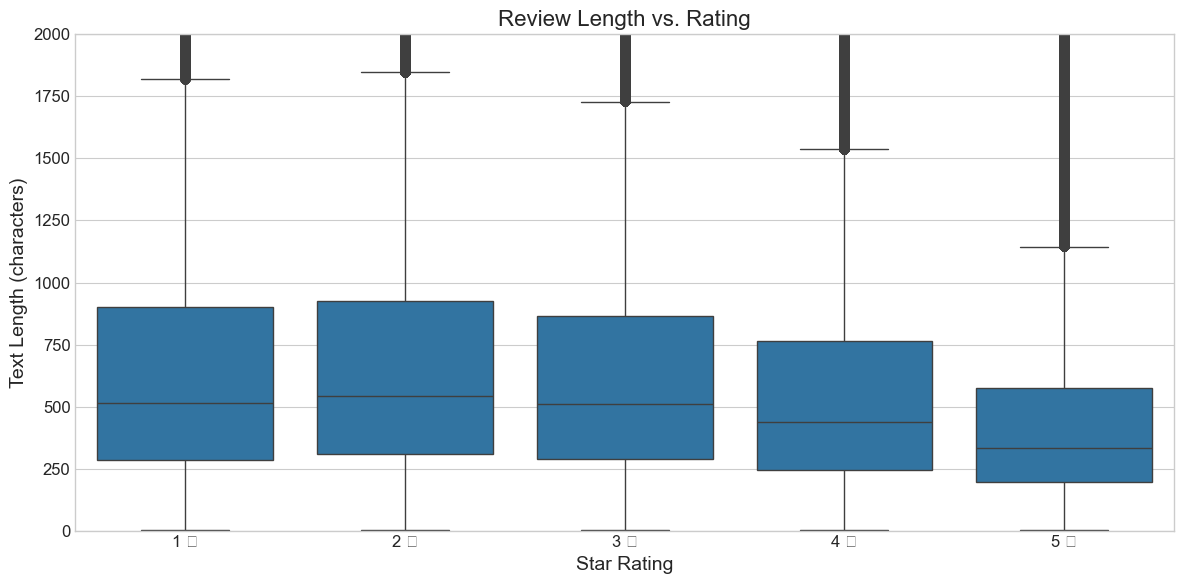

Average review length by star rating:
1.0 stars: 713.78 characters
2.0 stars: 721.08 characters
3.0 stars: 669.20 characters
4.0 stars: 587.50 characters
5.0 stars: 463.02 characters


In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='stars', y='text_length', data=df)
plt.title('Review Length vs. Rating', fontsize=16)
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Text Length (characters)', fontsize=14)
plt.xticks([0, 1, 2, 3, 4], ['1 ★', '2 ★', '3 ★', '4 ★', '5 ★'])
plt.ylim(0, 2000)  
plt.tight_layout()
plt.show()


avg_length_by_rating = df.groupby('stars')['text_length'].mean().reset_index()
print("Average review length by star rating:")
for _, row in avg_length_by_rating.iterrows():
    print(f"{row['stars']} stars: {row['text_length']:.2f} characters")

#

In [ ]:
df['total_feedback'] = df['useful'] + df['funny'] + df['cool']

feedback_stats = df[['useful', 'funny', 'cool', 'total_feedback']].describe()
feedback_stats

useful         funny          cool  total_feedback
count  6.990280e+06  6.990280e+06  6.990280e+06    6.990280e+06
mean   1.184609e+00  3.265596e-01  4.986175e-01    2.009786e+00
std    3.253767e+00  1.688729e+00  2.172460e+00    6.196532e+00
min   -1.000000e+00 -1.000000e+00 -1.000000e+00   -3.000000e+00
25%    0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00
50%    0.000000e+00  0.000000e+00  0.000000e+00    1.000000e+00
75%    1.000000e+00  0.000000e+00  0.000000e+00    2.000000e+00
max    1.182000e+03  7.920000e+02  4.040000e+02    1.182000e+03

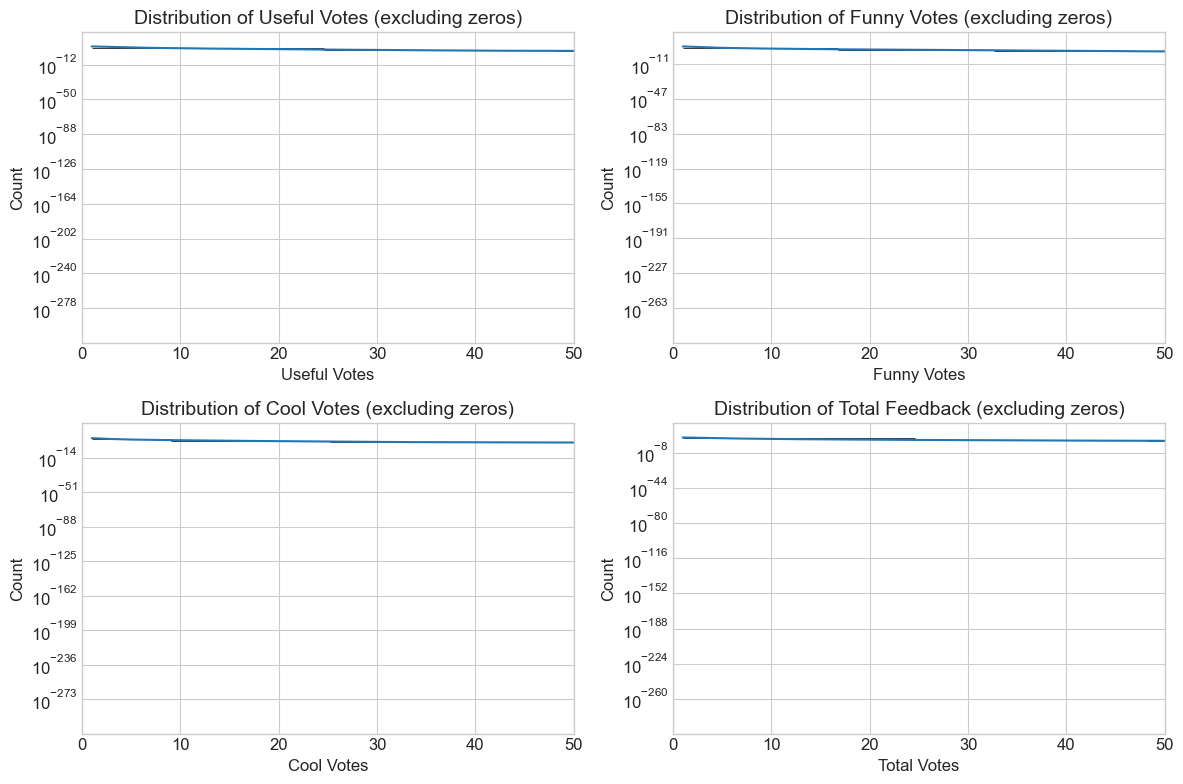

Percentage of reviews with at least one useful vote: 45.06%
Percentage of reviews with at least one funny vote: 15.68%
Percentage of reviews with at least one cool vote: 23.07%
Percentage of reviews with any feedback: 50.74%


In [ ]:
plt.figure(figsize=(12, 8))


plt.subplot(2, 2, 1)
sns.histplot(df['useful'][df['useful'] > 0], bins=50, kde=True, log_scale=(False, True))
plt.title('Distribution of Useful Votes (excluding zeros)', fontsize=14)
plt.xlabel('Useful Votes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlim(0, 50)  

plt.subplot(2, 2, 2)
sns.histplot(df['funny'][df['funny'] > 0], bins=50, kde=True, log_scale=(False, True))
plt.title('Distribution of Funny Votes (excluding zeros)', fontsize=14)
plt.xlabel('Funny Votes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlim(0, 50)  

plt.subplot(2, 2, 3)
sns.histplot(df['cool'][df['cool'] > 0], bins=50, kde=True, log_scale=(False, True))
plt.title('Distribution of Cool Votes (excluding zeros)', fontsize=14)
plt.xlabel('Cool Votes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlim(0, 50)  

plt.subplot(2, 2, 4)
sns.histplot(df['total_feedback'][df['total_feedback'] > 0], bins=50, kde=True, log_scale=(False, True))
plt.title('Distribution of Total Feedback (excluding zeros)', fontsize=14)
plt.xlabel('Total Votes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlim(0, 50)  

plt.tight_layout()
plt.show()


print(f"Percentage of reviews with at least one useful vote: {(df['useful'] > 0).mean() * 100:.2f}%")
print(f"Percentage of reviews with at least one funny vote: {(df['funny'] > 0).mean() * 100:.2f}%")
print(f"Percentage of reviews with at least one cool vote: {(df['cool'] > 0).mean() * 100:.2f}%")
print(f"Percentage of reviews with any feedback: {(df['total_feedback'] > 0).mean() * 100:.2f}%")

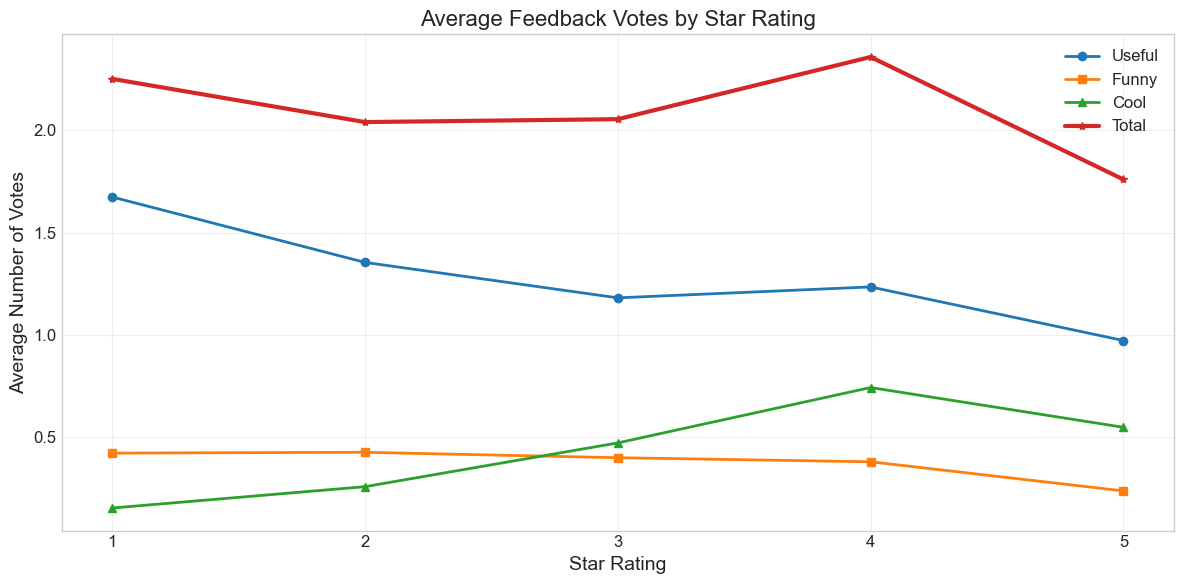

stars    useful     funny      cool  total_feedback
0    1.0  1.673746  0.422610  0.154404        2.250759
1    2.0  1.354246  0.426679  0.258720        2.039646
2    3.0  1.181042  0.400245  0.472440        2.053726
3    4.0  1.234359  0.380260  0.742942        2.357562
4    5.0  0.972549  0.237988  0.548700        1.759237

In [ ]:
feedback_by_rating = df.groupby('stars')[['useful', 'funny', 'cool', 'total_feedback']].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(feedback_by_rating['stars'], feedback_by_rating['useful'], marker='o', linewidth=2, label='Useful')
plt.plot(feedback_by_rating['stars'], feedback_by_rating['funny'], marker='s', linewidth=2, label='Funny')
plt.plot(feedback_by_rating['stars'], feedback_by_rating['cool'], marker='^', linewidth=2, label='Cool')
plt.plot(feedback_by_rating['stars'], feedback_by_rating['total_feedback'], marker='*', linewidth=3, label='Total')
plt.title('Average Feedback Votes by Star Rating', fontsize=16)
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Average Number of Votes', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.show()


feedback_by_rating

#

In [ ]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['hour'] = df['date'].dt.hour

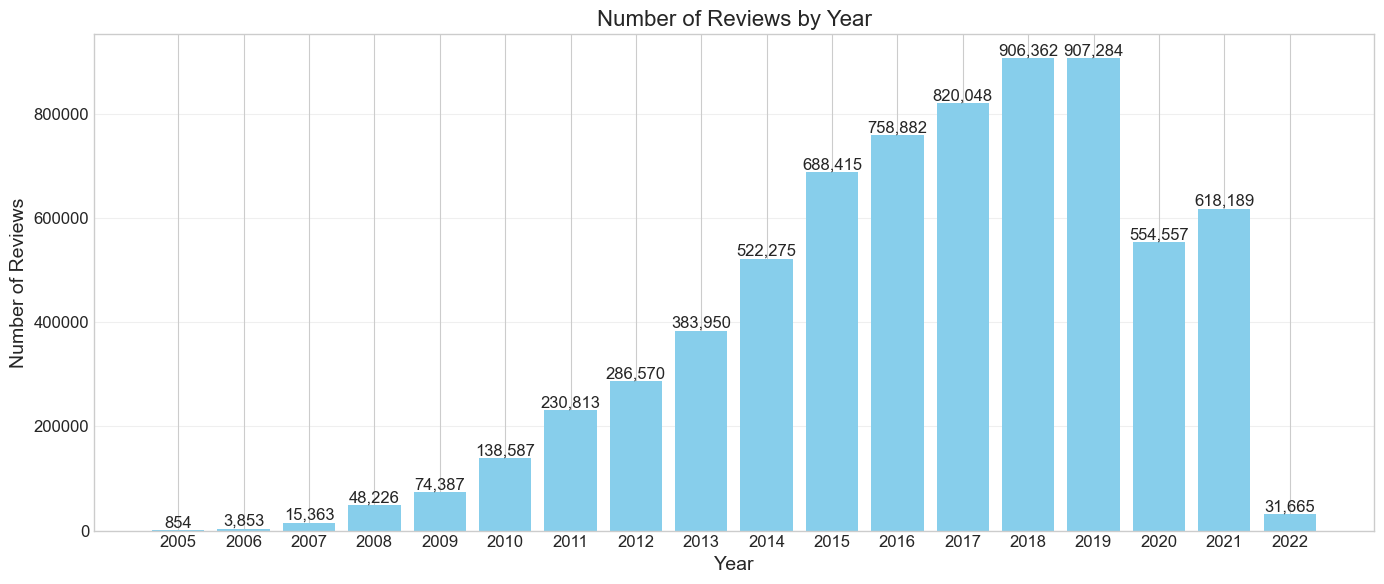

In [ ]:
reviews_by_year = df.groupby('year').size().reset_index(name='count')

plt.figure(figsize=(14, 6))
plt.bar(reviews_by_year['year'], reviews_by_year['count'], color='skyblue')
plt.title('Number of Reviews by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(reviews_by_year['year'])
plt.grid(axis='y', alpha=0.3)


for i, row in reviews_by_year.iterrows():
    plt.text(row['year'], row['count'] + 5000, f"{row['count']:,}", ha='center')

plt.tight_layout()
plt.show()

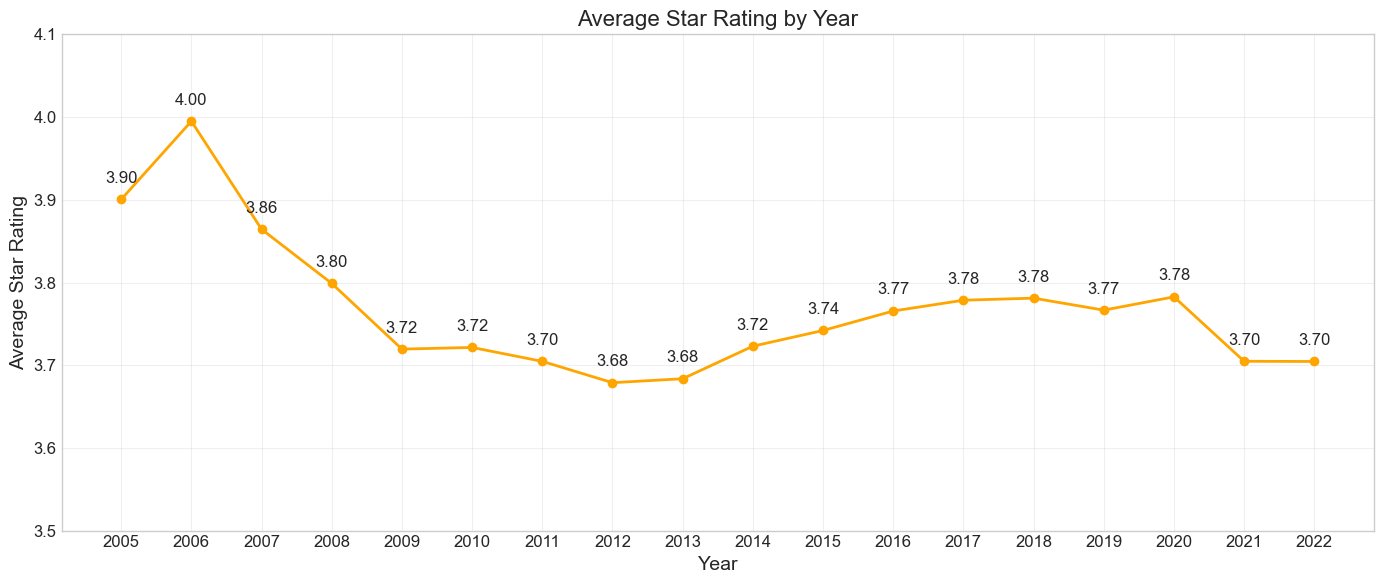

In [ ]:
ratings_by_year = df.groupby('year')['stars'].mean().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(ratings_by_year['year'], ratings_by_year['stars'], marker='o', linewidth=2, color='orange')
plt.title('Average Star Rating by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Star Rating', fontsize=14)
plt.xticks(ratings_by_year['year'])
plt.grid(True, alpha=0.3)
plt.ylim(3.5, 4.1)  


for i, row in ratings_by_year.iterrows():
    plt.text(row['year'], row['stars'] + 0.02, f"{row['stars']:.2f}", ha='center')

plt.tight_layout()
plt.show()

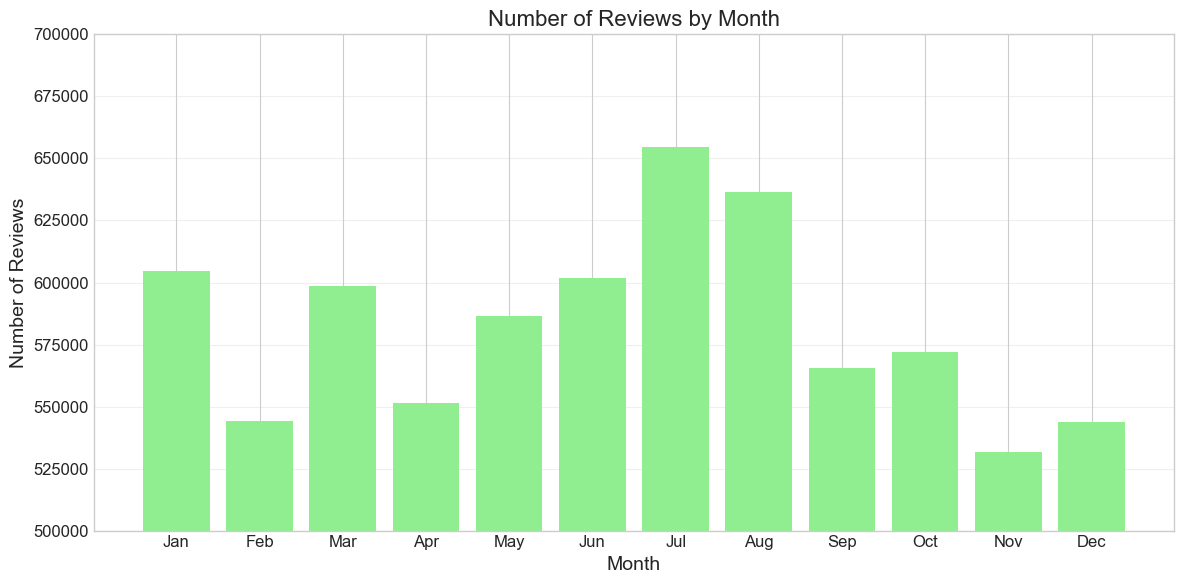

In [ ]:
reviews_by_month = df.groupby('month').size().reset_index(name='count')
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12, 6))
plt.bar(reviews_by_month['month'], reviews_by_month['count'], color='lightgreen')
plt.title('Number of Reviews by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.ylim(500000,700000)
plt.xticks(range(1, 13), month_names)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

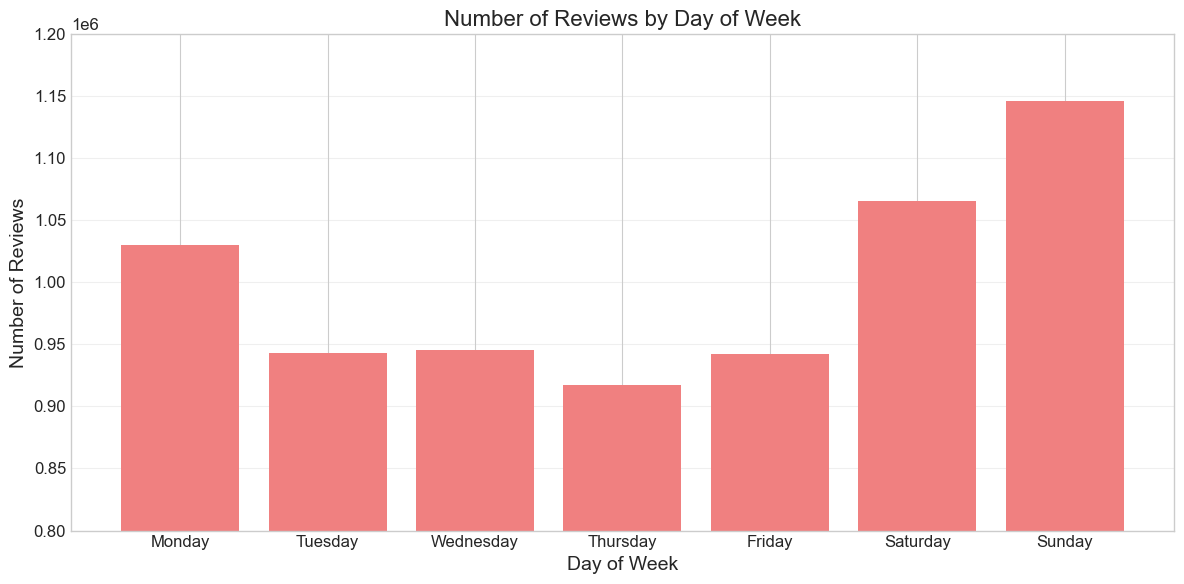

In [ ]:
reviews_by_dow = df.groupby('day_of_week').size().reset_index(name='count')
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
plt.bar(reviews_by_dow['day_of_week'], reviews_by_dow['count'], color='lightcoral')
plt.title('Number of Reviews by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.ylim(0.8e6,1.2e6)  
plt.xticks(range(7), day_names)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

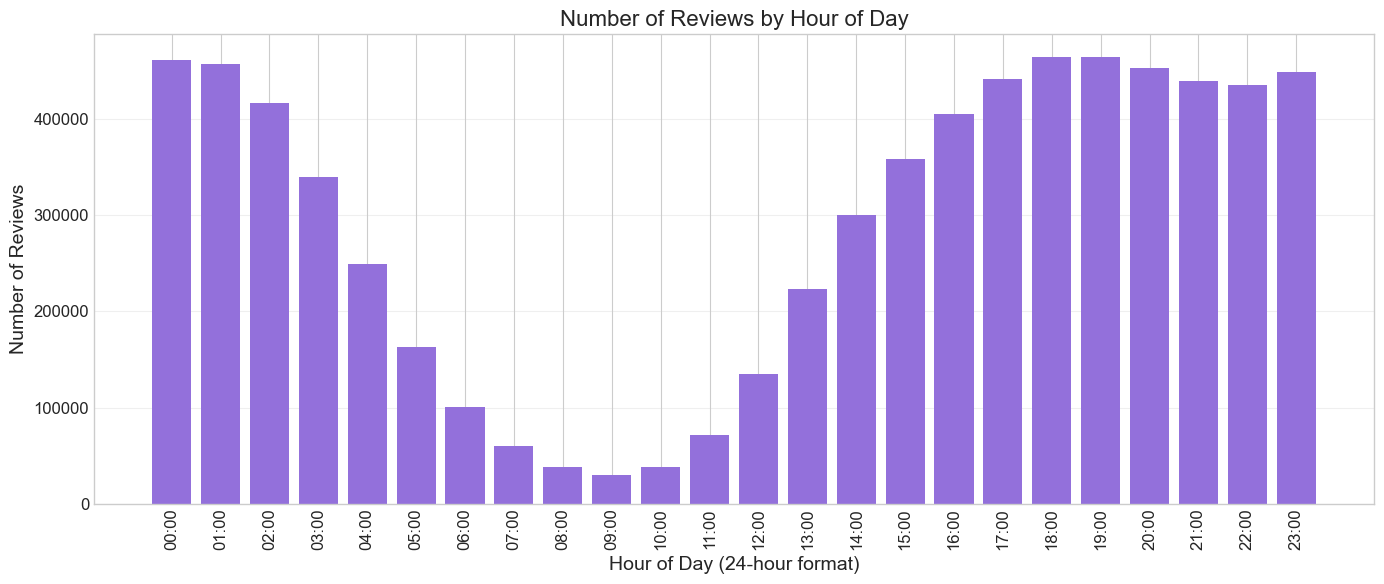

In [ ]:
reviews_by_hour = df.groupby('hour').size().reset_index(name='count')

plt.figure(figsize=(14, 6))
plt.bar(reviews_by_hour['hour'], reviews_by_hour['count'], color='mediumpurple')
plt.title('Number of Reviews by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (24-hour format)', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(range(24), [f"{h:02d}:00" for h in range(24)], rotation=90)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\suyog\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\suyog\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def extract_words(text):
    
    text = text.lower()
    
    
    tokens = word_tokenize(text)
    
    
    stop_words = set(stopwords.words('english'))
    words = [word for word in tokens if word isalpha() and word not in stop_words and len(word) > 2]
    
    return words


sample_size = min(100000, len(df))
text_sample = df.sample(sample_size, random_state=42)

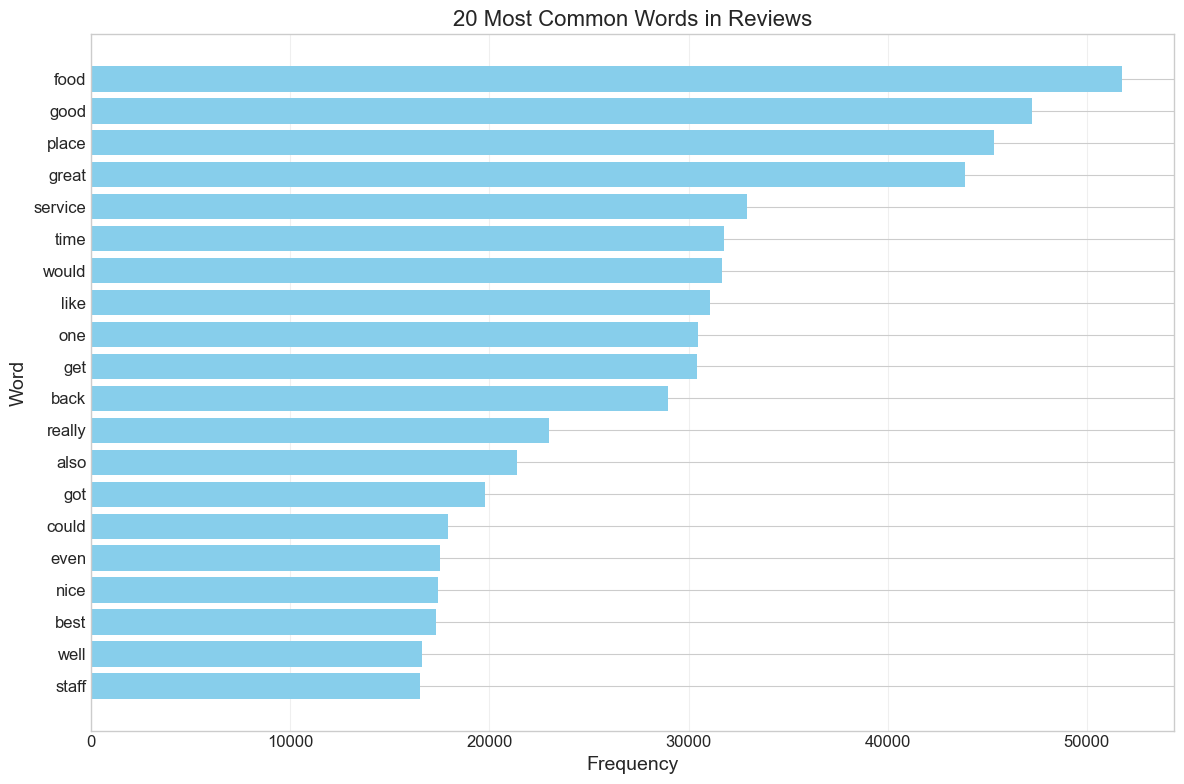

In [ ]:
all_words = []
for text in text_sample['text']:
    all_words.extend(extract_words(text))


word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)


plt.figure(figsize=(12, 8))
words, counts = zip(*most_common_words)
plt.barh(words, counts, color='skyblue')
plt.gca().invert_yaxis()  
plt.title('20 Most Common Words in Reviews', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Word', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

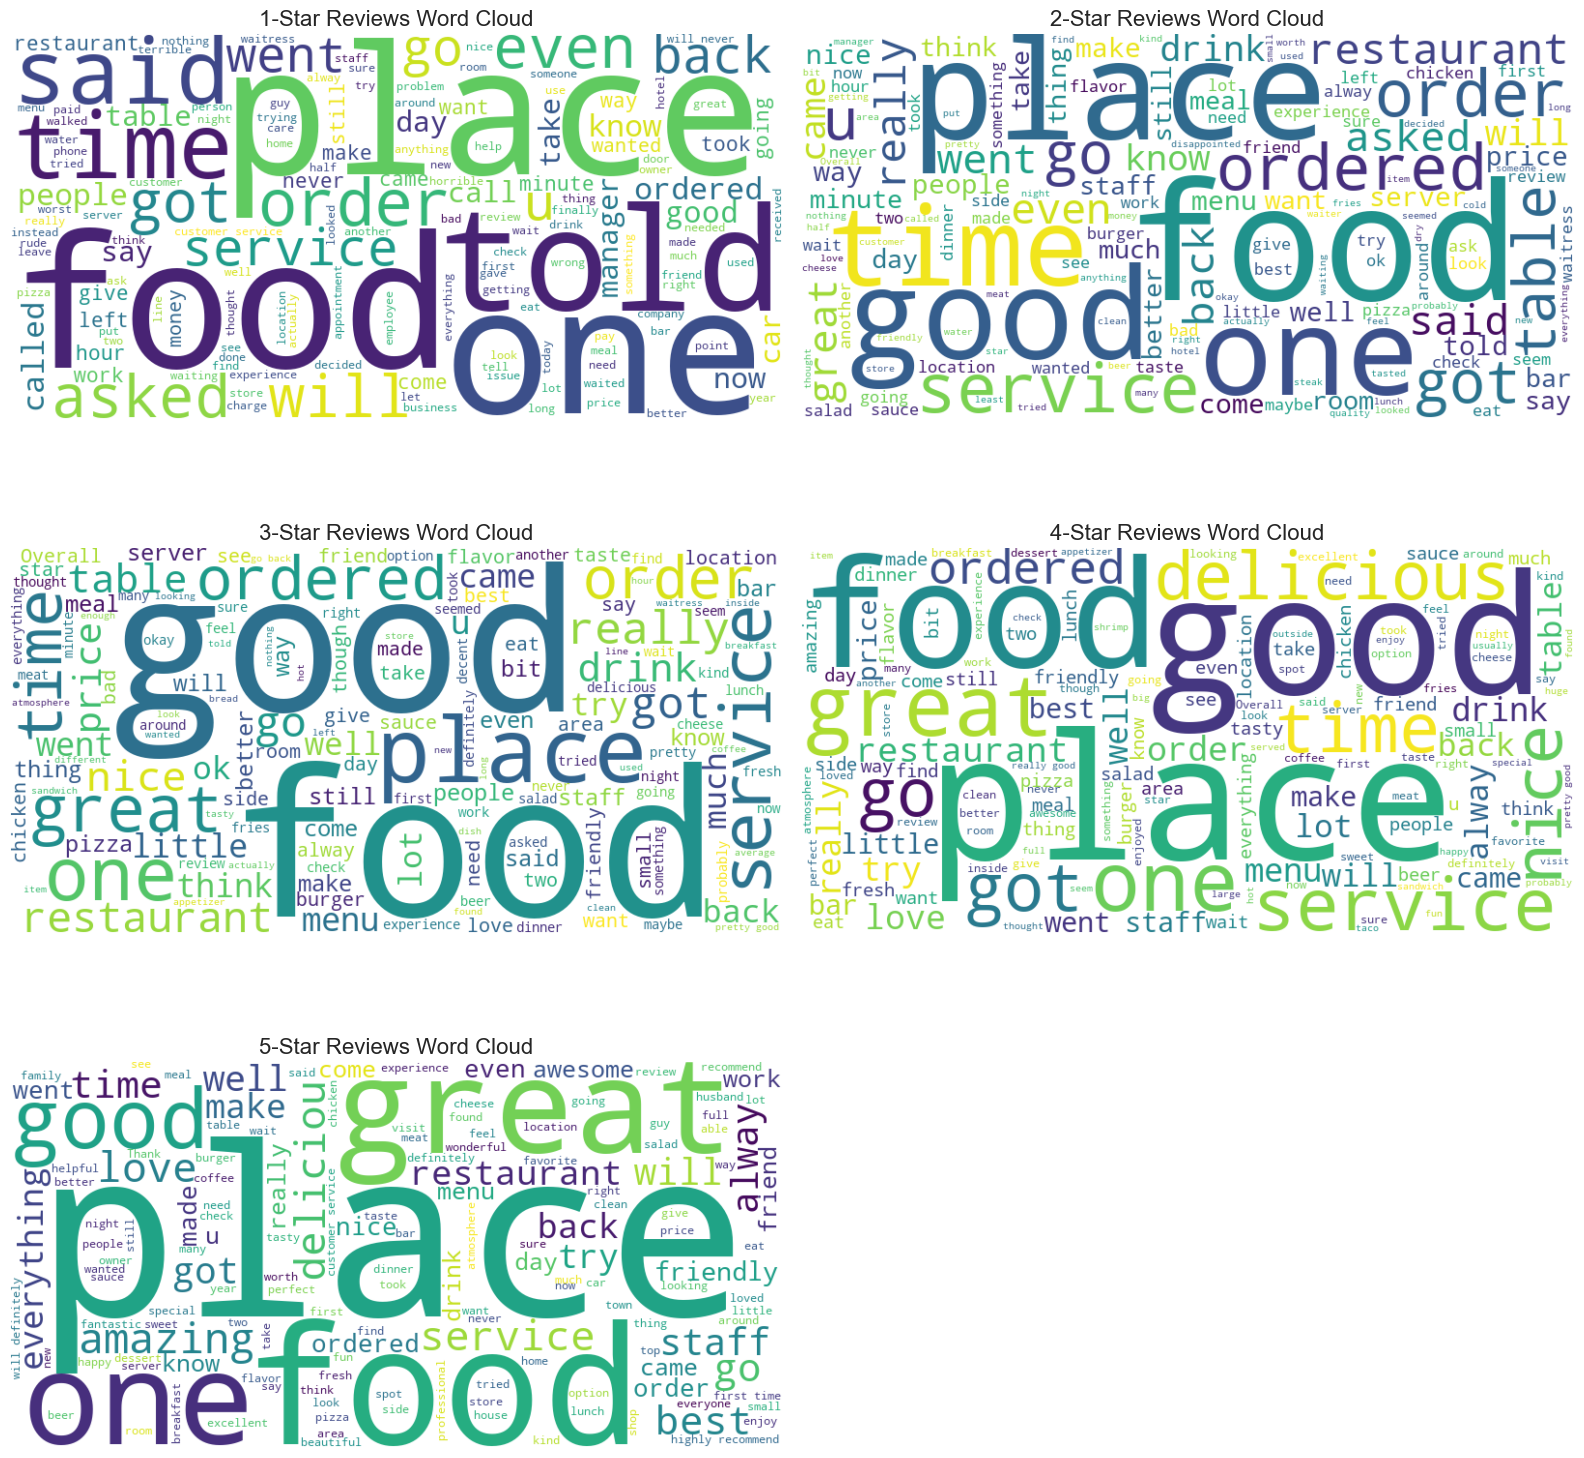

In [ ]:
plt.figure(figsize=(16, 16))

for i, rating in enumerate(range(1, 6)):
    
    rating_sample = text_sample[text_sample['stars'] == rating]
    
    
    rating_text = ' '.join(rating_sample['text'].astype(str))
    
    
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white', 
                          max_words=150, 
                          contour_width=3, 
                          colormap='viridis').generate(rating_text)
    
    
    plt.subplot(3, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{rating}-Star Reviews Word Cloud', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()

#

In [ ]:
user_stats = df.groupby('user_id').agg({
    'review_id': 'count',  
    'stars': 'mean',       
    'text_length': 'mean', 
    'useful': 'sum',       
    'funny': 'sum',        
    'cool': 'sum'          
}).reset_index()

user_stats.rename(columns={'review_id': 'review_count'}, inplace=True)


print(f"Total number of unique users: {len(user_stats)}")
user_stats.describe()

Total number of unique users: 1987929


review_count         stars   text_length        useful         funny  \
count  1.987929e+06  1.987929e+06  1.987929e+06  1.987929e+06  1.987929e+06   
mean   3.516363e+00  3.604842e+00  5.053621e+02  4.165515e+00  1.148302e+00   
std    1.277088e+01  1.507412e+00  4.461081e+02  6.455382e+01  2.900963e+01   
min    1.000000e+00  1.000000e+00  1.000000e+00 -1.000000e+00 -1.000000e+00   
25%    1.000000e+00  2.400000e+00  2.270000e+02  0.000000e+00  0.000000e+00   
50%    1.000000e+00  4.000000e+00  3.770000e+02  0.000000e+00  0.000000e+00   
75%    3.000000e+00  5.000000e+00  6.260000e+02  2.000000e+00  0.000000e+00   
max    3.048000e+03  5.000000e+00  5.000000e+03  3.469400e+04  1.777400e+04   

               cool  
count  1.987929e+06  
mean   1.753320e+00  
std    4.875223e+01  
min   -1.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    2.674900e+04

In [ ]:
business_stats = df.groupby('business_id').agg({
    'review_id': 'count',  
    'stars': 'mean',       
    'useful': 'mean',      
    'funny': 'mean',       
    'cool': 'mean'         
}).reset_index()

business_stats.rename(columns={'review_id': 'review_count'}, inplace=True)


print(f"Total number of unique businesses: {len(business_stats)}")
business_stats.describe()

Total number of unique businesses: 150346


review_count          stars         useful          funny  \
count  150346.000000  150346.000000  150346.000000  150346.000000   
mean       46.494619       3.587534       1.362728       0.337443   
std       124.519061       0.961807       1.535757       0.571791   
min         5.000000       1.000000       0.000000       0.000000   
25%         8.000000       2.948718       0.600000       0.071429   
50%        15.000000       3.727273       1.000000       0.200000   
75%        38.000000       4.333333       1.673913       0.411765   
max      7673.000000       5.000000     222.152174      36.457944   

                cool  
count  150346.000000  
mean        0.472892  
std         0.788716  
min         0.000000  
25%         0.117647  
50%         0.285714  
75%         0.578313  
max        70.308458

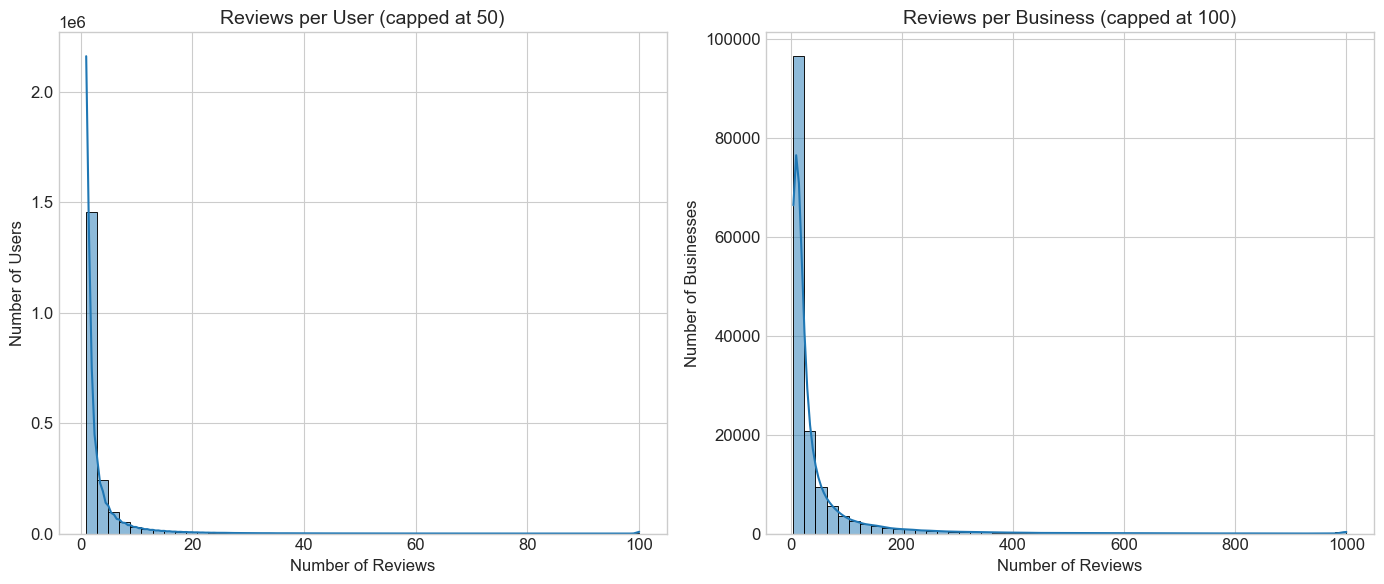

Average reviews per user: 3.52
Median reviews per user: 1.00
Maximum reviews per user: 3048

Average reviews per business: 46.49
Median reviews per business: 15.00
Maximum reviews per business: 7673


In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(user_stats['review_count'].clip(upper=100), bins=50, kde=True)
plt.title('Reviews per User (capped at 100)', fontsize=14)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)

plt.subplot(1, 2, 2)
sns.histplot(business_stats['review_count'].clip(upper=1000), bins=50, kde=True)
plt.title('Reviews per Business (capped at 1000)', fontsize=14)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Number of Businesses', fontsize=12)

plt.tight_layout()
plt.show()


print(f"Average reviews per user: {user_stats['review_count'].mean():.2f}")
print(f"Median reviews per user: {user_stats['review_count'].median():.2f}")
print(f"Maximum reviews per user: {user_stats['review_count'].max()}")
print(f"\nAverage reviews per business: {business_stats['review_count'].mean():.2f}")
print(f"Median reviews per business: {business_stats['review_count'].median():.2f}")
print(f"Maximum reviews per business: {business_stats['review_count'].max()}")

#

In [ ]:
from textblob import TextBlob

def get_sentiment_polarity(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return 0

sentiment_sample = df.sample(min(20000, len(df)), random_state=42)

sentiment_sample['sentiment'] = sentiment_sample['text'].apply(get_sentiment_polarity)

C:\Users\suyog\AppData\Local\Temp\ipykernel_44800\2055677366.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stars', y='sentiment', data=sentiment_sample, palette='viridis')
C:\Users\suyog\AppData\Local\Temp\ipykernel_44800\2055677366.py:9: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\suyog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


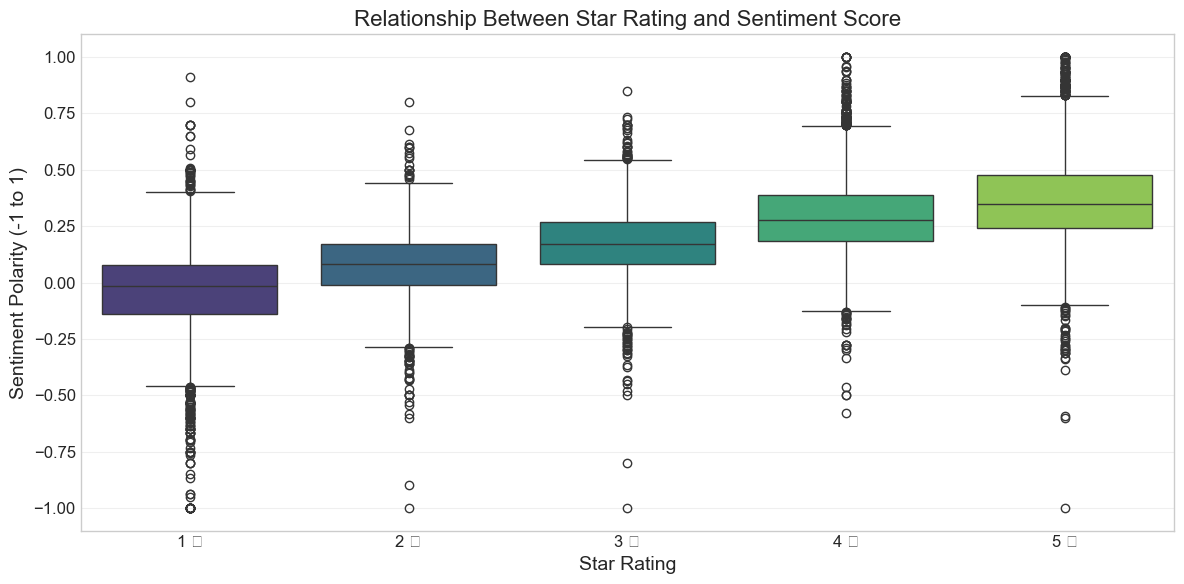

Average sentiment score by star rating:
1.0 stars: -0.0430
2.0 stars: 0.0731
3.0 stars: 0.1730
4.0 stars: 0.2924
5.0 stars: 0.3650


In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='stars', y='sentiment', data=sentiment_sample, palette='viridis')
plt.title('Relationship Between Star Rating and Sentiment Score', fontsize=16)
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Sentiment Polarity (-1 to 1)', fontsize=14)
plt.xticks([0, 1, 2, 3, 4], ['1 ★', '2 ★', '3 ★', '4 ★', '5 ★'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


sentiment_by_rating = sentiment_sample.groupby('stars')['sentiment'].mean().reset_index()
print("Average sentiment score by star rating:")
for _, row in sentiment_by_rating.iterrows():
    print(f"{row['stars']} stars: {row['sentiment']:.4f}")

In [46]:
business_data = pd.read_csv('yelp_business_analysis.csv')
business_data.head()

business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.955505  -75.155564    4.0            80        1   
4  40.338183  -75.471659    4.5            13        1   

                                          attributes  \
0                      {'ByAppointmentOnly': 'True'}   
1             {'BusinessAcceptsCreditCards': 'True'}   
2  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
3  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
4  {'BusinessAcceptsCreditCards': 'True', 'Wheelc...   

                                          categories  \
0  Doctors, Traditional Chinese Medicine, Naturop...   
1  Shipping Centers, Local Services, Notaries, Ma...   
2  Department Stores, Shopping, Fashion, Home & G...   
3  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
4                          Brewpubs, Breweries, Food   

                                               hours review_bin  \
0                                                NaN       0-10   
1  {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...      11-50   
2  {'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...      11-50   
3  {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...     51-100   
4  {'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...      11-50   

   success_score  is_successful  category_count  
0           2.50          False             6.0  
1           4.50          False             5.0  
2           1.75          False             6.0  
3           6.00           True             5.0  
4           6.75           True             3.0

In [6]:
df.to_csv('yelp_reviews.csv', index=False, encoding='utf-8')

### Let's explore the business data and combine it with our review analysis to get further insights.

In [ ]:
print(f"Business data shape: {business_data.shape}")
business_data.info()
business_data.head()

Business data shape: (150346, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   business_id     150346 non-null  object 
 1   name            150346 non-null  object 
 2   address         145219 non-null  object 
 3   city            150346 non-null  object 
 4   state           150346 non-null  object 
 5   postal_code     150273 non-null  object 
 6   latitude        150346 non-null  float64
 7   longitude       150346 non-null  float64
 8   stars           150346 non-null  float64
 9   review_count    150346 non-null  int64  
 10  is_open         150346 non-null  int64  
 11  attributes      136602 non-null  object 
 12  categories      150243 non-null  object 
 13  hours           127123 non-null  object 
 14  review_bin      150346 non-null  object 
 15  success_score   150346 non-null  float64
 16  is_successful   150346

business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.955505  -75.155564    4.0            80        1   
4  40.338183  -75.471659    4.5            13        1   

                                          attributes  \
0                      {'ByAppointmentOnly': 'True'}   
1             {'BusinessAcceptsCreditCards': 'True'}   
2  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
3  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
4  {'BusinessAcceptsCreditCards': 'True', 'Wheelc...   

                                          categories  \
0  Doctors, Traditional Chinese Medicine, Naturop...   
1  Shipping Centers, Local Services, Notaries, Ma...   
2  Department Stores, Shopping, Fashion, Home & G...   
3  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
4                          Brewpubs, Breweries, Food   

                                               hours review_bin  \
0                                                NaN       0-10   
1  {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...      11-50   
2  {'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...      11-50   
3  {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...     51-100   
4  {'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...      11-50   

   success_score  is_successful  category_count  
0           2.50          False             6.0  
1           4.50          False             5.0  
2           1.75          False             6.0  
3           6.00           True             5.0  
4           6.75           True             3.0

C:\Users\suyog\AppData\Local\Temp\ipykernel_44800\3464281083.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')


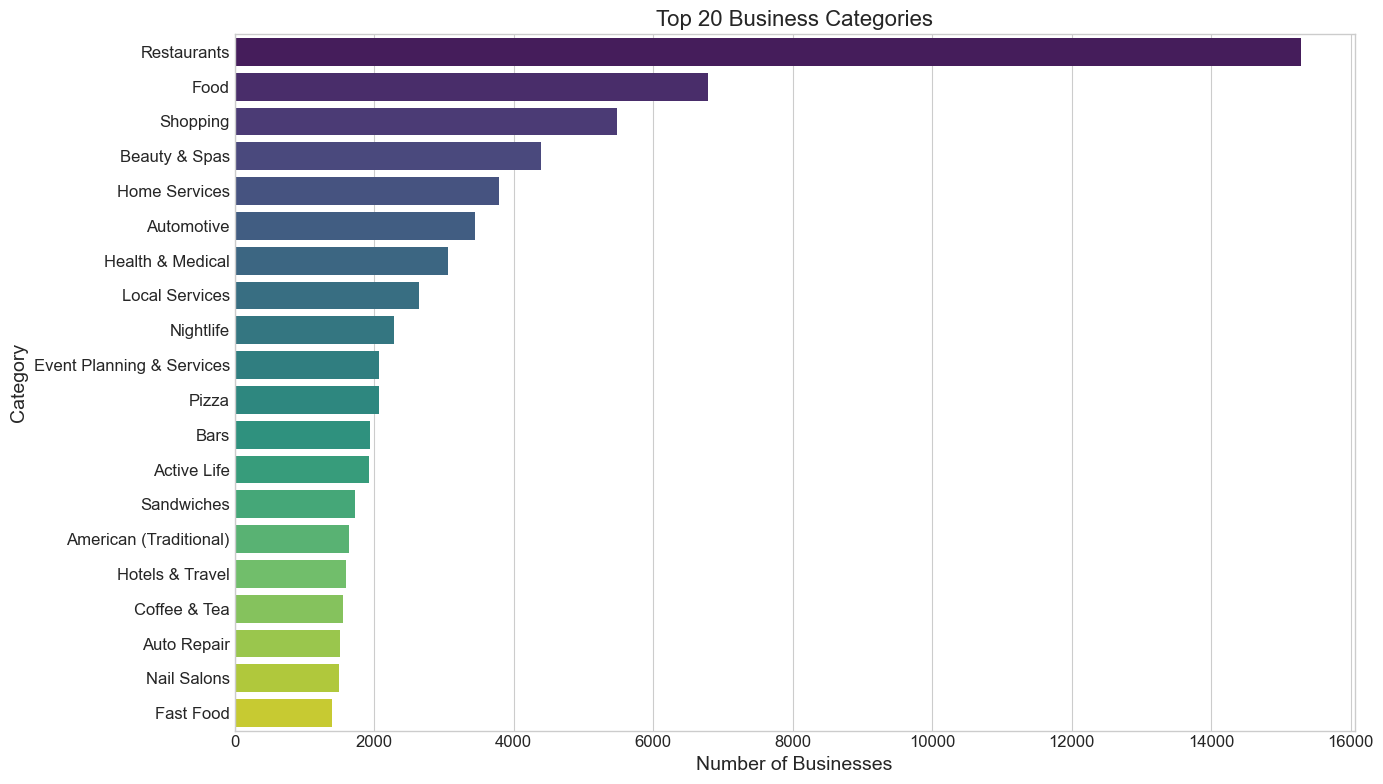

In [ ]:
def get_primary_category(categories_str):
    if isinstance(categories_str, str):
        categories = categories_str.split(', ')
        return categories[0] if categories else 'Uncategorized'
    return 'Uncategorized'

business_data['primary_category'] = business_data['categories'].apply(get_primary_category)


top_categories = business_data['primary_category'].value_counts().head(20)

plt.figure(figsize=(14, 8))
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.title('Top 20 Business Categories', fontsize=16)
plt.xlabel('Number of Businesses', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
merged_sample = pd.merge(
    df,
    business_data[['business_id', 'name', 'city', 'state', 'stars', 'review_count', 'primary_category']],
    on='business_id',
    suffixes=('_review', '_business')
)

merged_sample.head()

review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars_review  useful  funny  cool  \
0           3.0       0      0     0   
1           5.0       1      0     1   
2           3.0       0      0     0   
3           5.0       1      0     1   
4           4.0       1      0     1   

                                                text                date  \
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11   
1  I've taken a lot of spin classes over the year... 2012-01-03 15:28:18   
2  Family diner. Had the buffet. Eclectic assortm... 2014-02-05 20:30:30   
3  Wow!  Yummy, different,  delicious.   Our favo... 2015-01-04 00:01:03   
4  Cute interior and owner (?) gave us tour of up... 2017-01-14 20:54:15   

   text_length  ...  year  month  day_of_week  hour  \
0          513  ...  2018      7            5    22   
1          829  ...  2012      1            1    15   
2          339  ...  2014      2            2    20   
3          243  ...  2015      1            6     0   
4          534  ...  2017      1            5    20   

                           name          city state stars_business  \
0  Turning Point of North Wales   North Wales    PA            3.0   
1    Body Cycle Spinning Studio  Philadelphia    PA            5.0   
2             Kettle Restaurant        Tucson    AZ            3.5   
3                         Zaika  Philadelphia    PA            4.0   
4                          Melt   New Orleans    LA            4.0   

   review_count  primary_category  
0           169       Restaurants  
1           144       Active Life  
2            47       Restaurants  
3           181             Halal  
4            32        Sandwiches  

[5 rows x 21 columns]

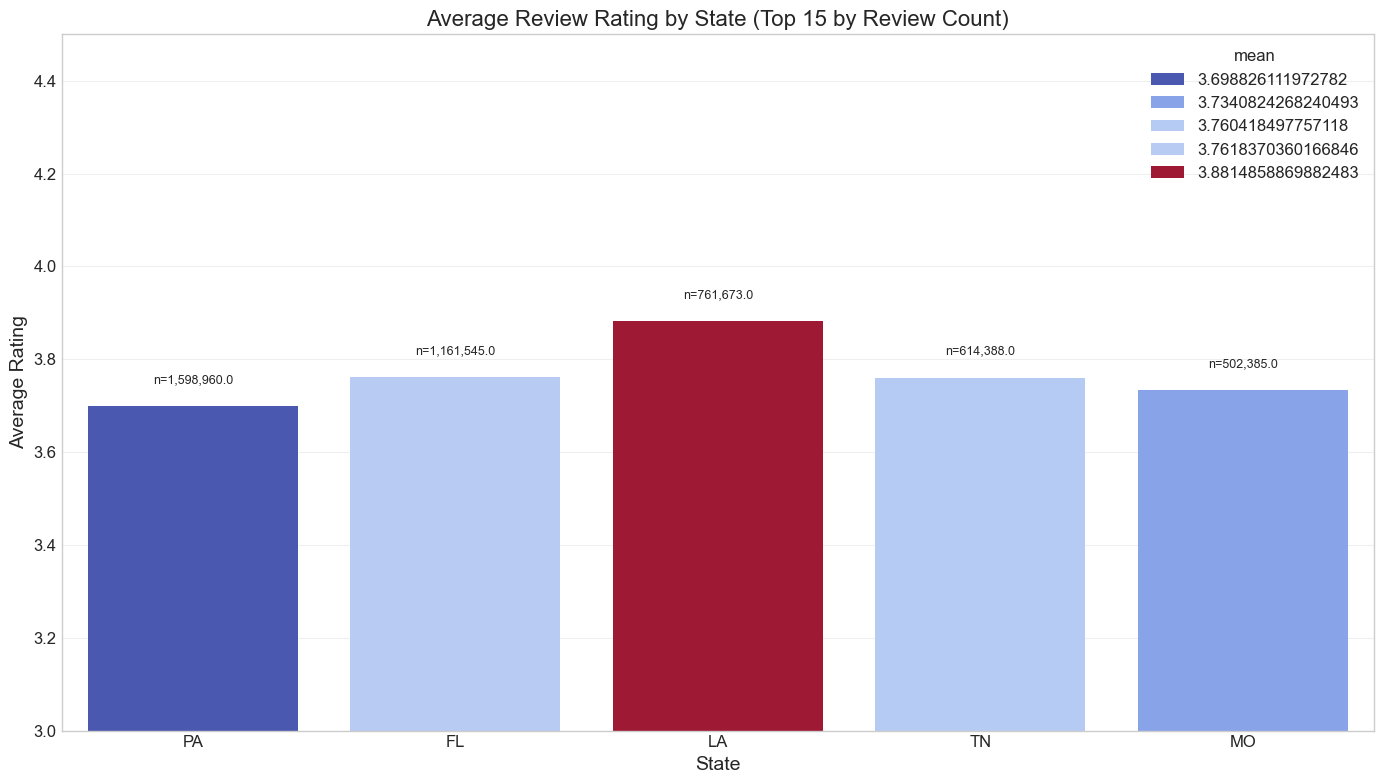

In [ ]:
state_ratings = merged_sample.groupby('state')['stars_review'].agg(['mean', 'count'])
state_ratings = state_ratings.sort_values('count', ascending=False).head(5)  

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=state_ratings.index, y=state_ratings['mean'], palette='coolwarm', hue=state_ratings['mean'])


for i, (_, row) in enumerate(state_ratings.iterrows()):
    ax.text(i, row['mean'] + 0.05, f"n={row['count']:,}", ha='center', fontsize=9)

plt.title('Average Review Rating by State (Top 15 by Review Count)', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.ylim(3.0, 4.5)  
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

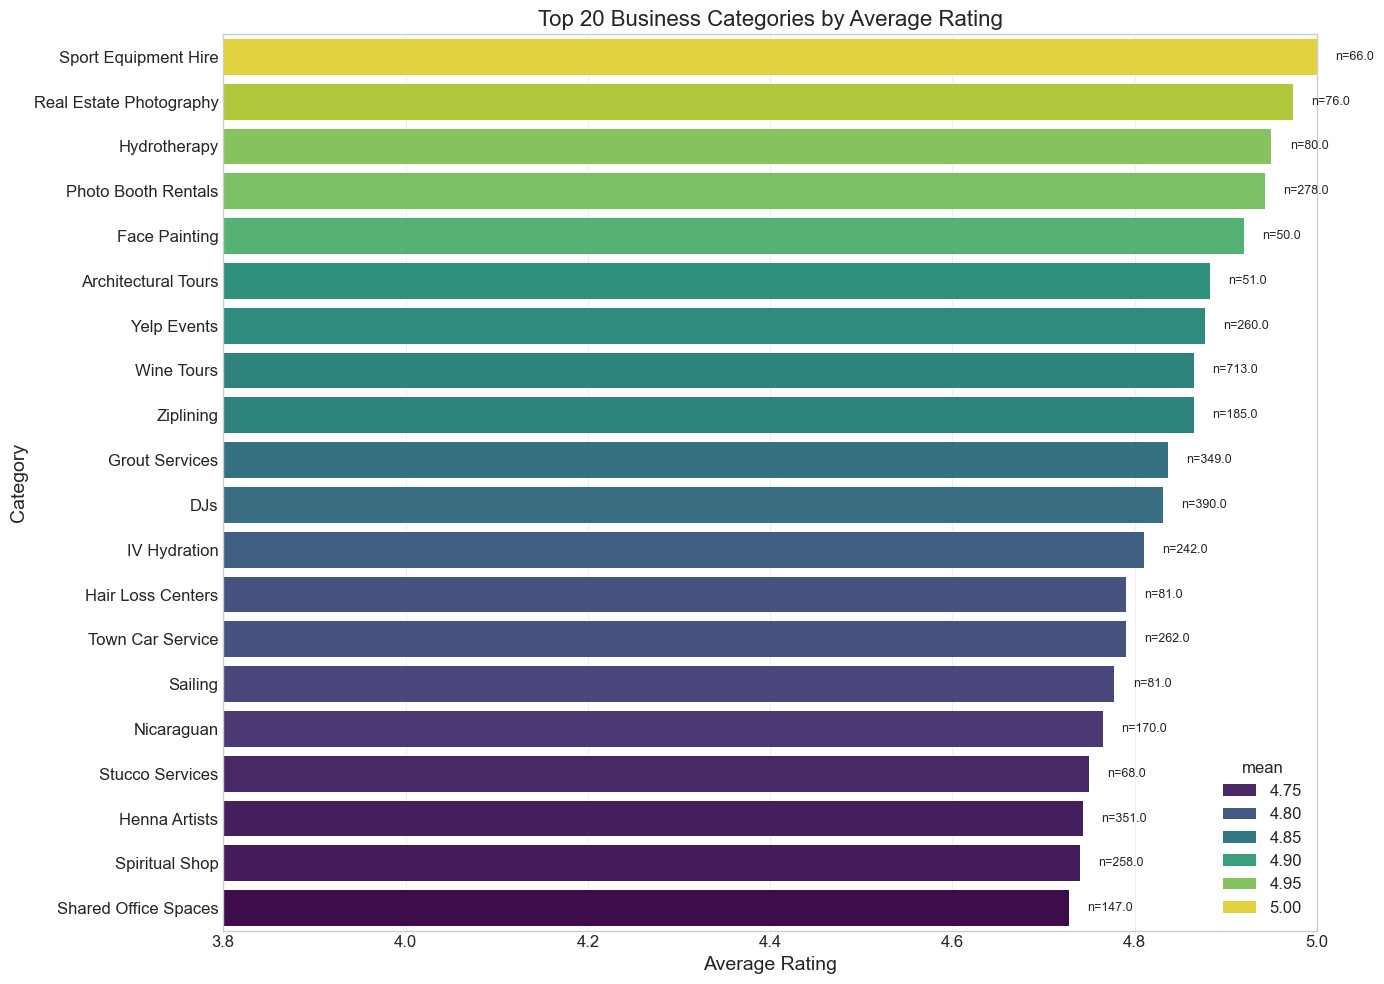

In [ ]:
category_ratings = merged_sample.groupby('primary_category')['stars_review'].agg(['mean', 'count'])

significant_categories = category_ratings[category_ratings['count'] >= 50].sort_values('mean', ascending=False)
top_20_categories = significant_categories.head(20)

plt.figure(figsize=(14, 10))
ax = sns.barplot(x=top_20_categories['mean'], y=top_20_categories.index, palette='viridis', hue=top_20_categories['mean'])


for i, (_, row) in enumerate(top_20_categories.iterrows()):
    ax.text(row['mean'] + 0.02, i, f"n={row['count']:,}", va='center', fontsize=9)

plt.title('Top 20 Business Categories by Average Rating', fontsize=16)
plt.xlabel('Average Rating', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.xlim(3.8, 5.0)  
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

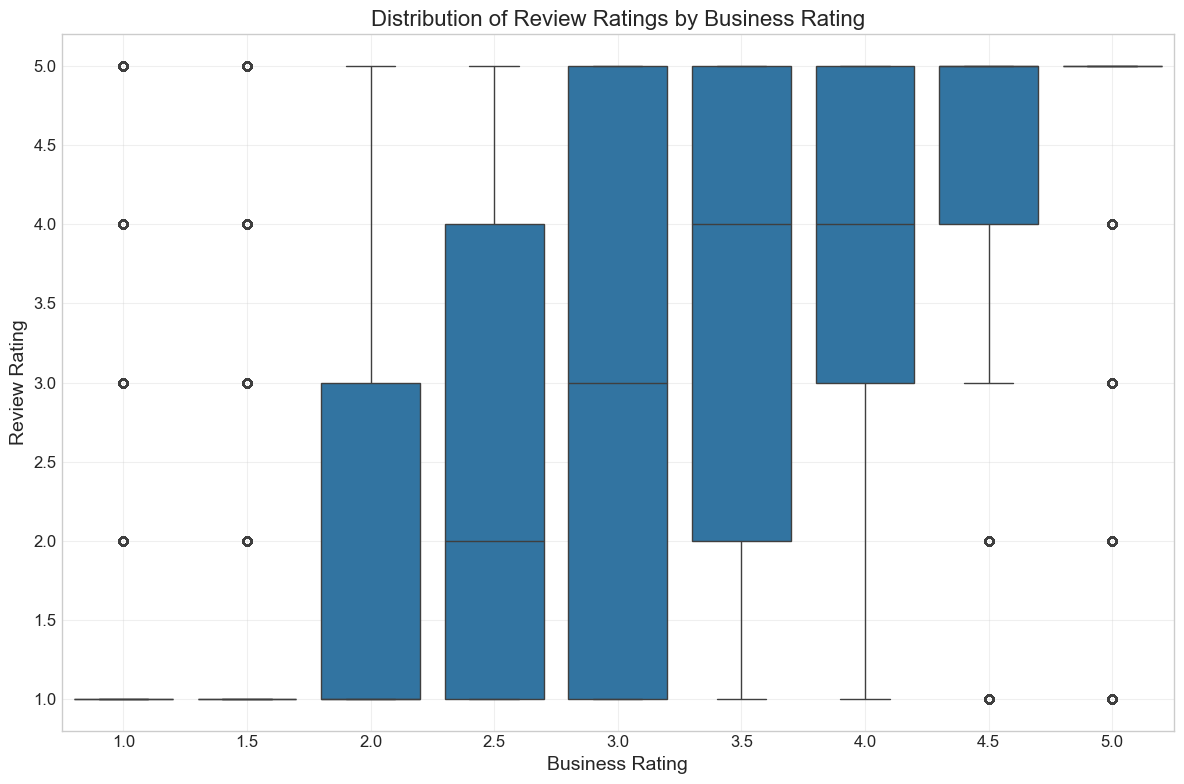

Correlation between business rating and review rating: 0.4894


In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='stars_business', y='stars_review', data=merged_sample)
plt.title('Distribution of Review Ratings by Business Rating', fontsize=16)
plt.xlabel('Business Rating', fontsize=14)
plt.ylabel('Review Rating', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


correlation = merged_sample['stars_business'].corr(merged_sample['stars_review'])
print(f"Correlation between business rating and review rating: {correlation:.4f}")

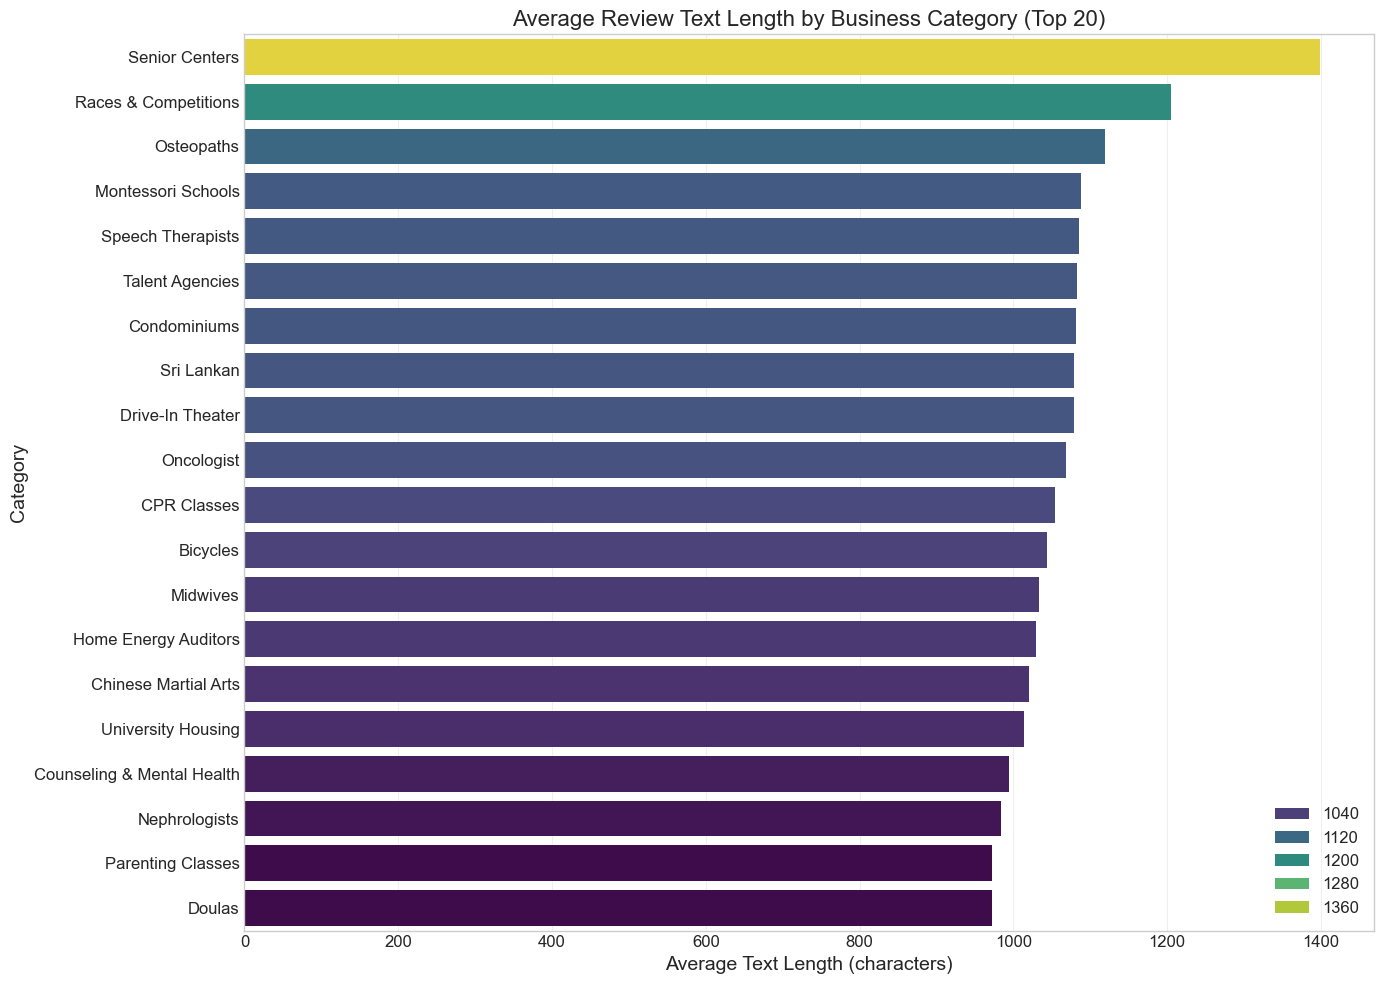

In [ ]:
text_category_sample = merged_sample


text_by_category = text_category_sample.groupby('primary_category')['text_length'].mean().sort_values(ascending=False)
top_20_text_categories = text_by_category.head(20)

plt.figure(figsize=(14, 10))
sns.barplot(x=top_20_text_categories.values, y=top_20_text_categories.index, palette='viridis', hue=top_20_text_categories.values)
plt.title('Average Review Text Length by Business Category (Top 20)', fontsize=16)
plt.xlabel('Average Text Length (characters)', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\suyog\AppData\Local\Temp\ipykernel_44800\1620366313.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment', y='primary_category', data=sentiment_by_category.head(10), ax=ax1, palette='Greens_d')
C:\Users\suyog\AppData\Local\Temp\ipykernel_44800\1620366313.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment', y='primary_category', data=sentiment_by_category.tail(10).iloc[::-1], ax=ax2, palette='Reds_d')


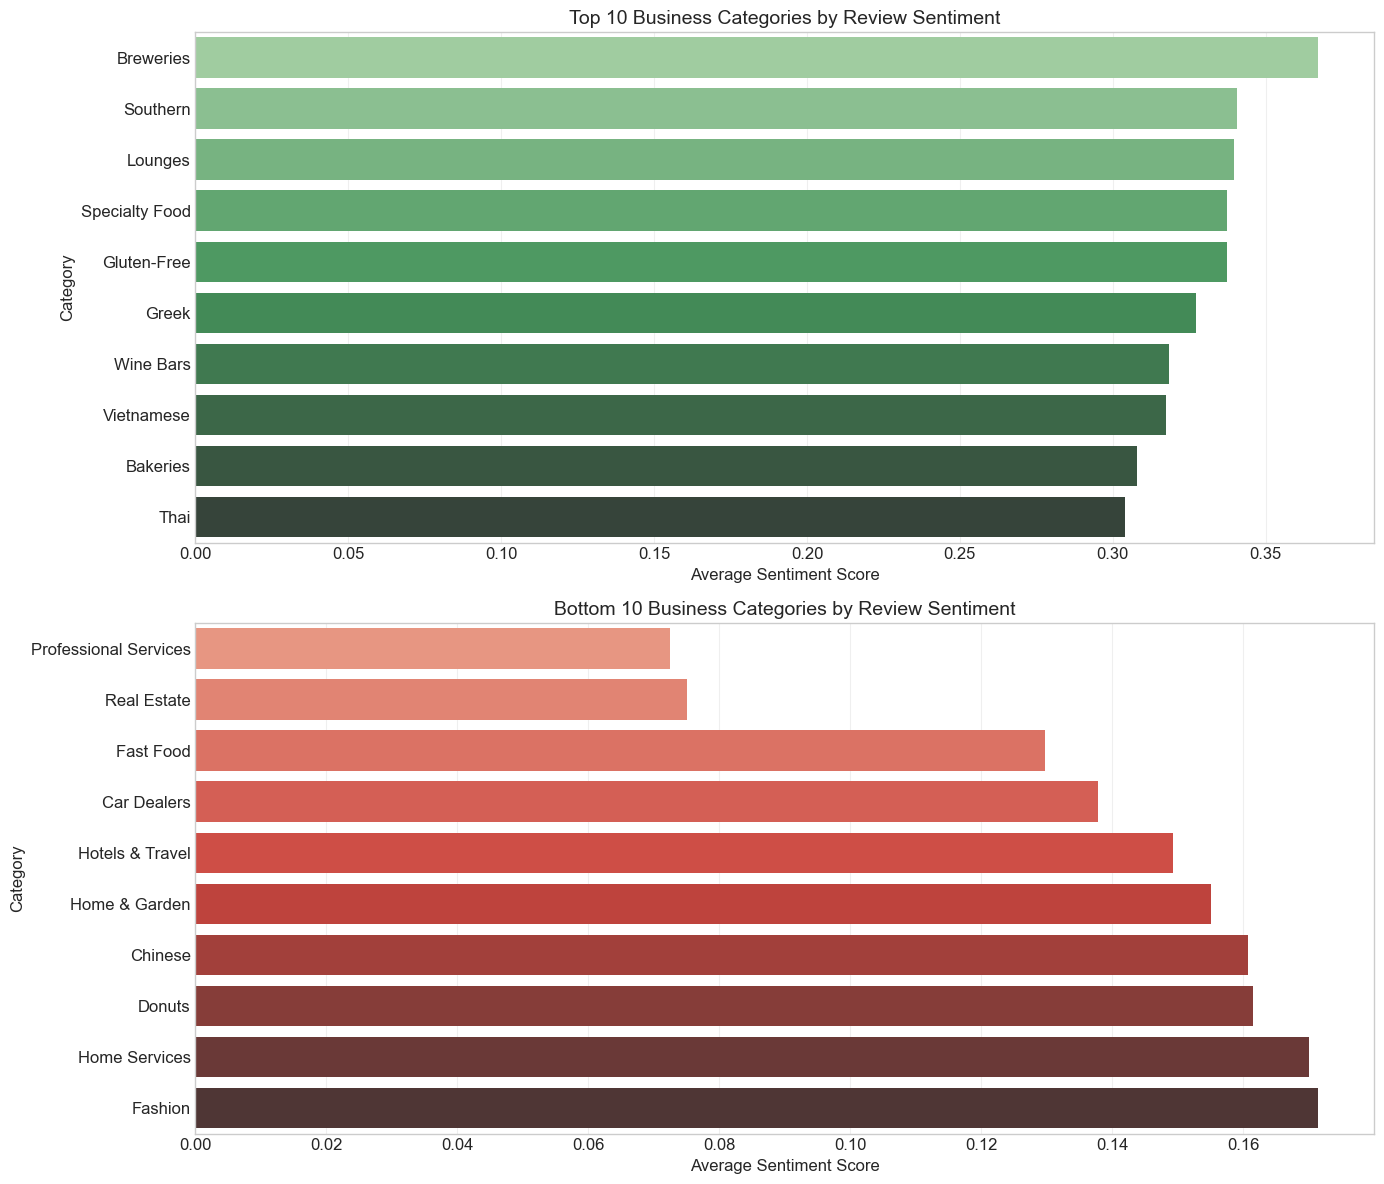

In [ ]:
sentiment_category_sample = merged_sample.sample(min(10000, len(merged_sample)), random_state=42)

sentiment_category_sample['sentiment'] = sentiment_category_sample['text'].apply(get_sentiment_polarity)

sentiment_by_category = sentiment_category_sample.groupby('primary_category').agg({
    'sentiment': 'mean',
    'review_id': 'count'  
}).reset_index()

sentiment_by_category = sentiment_by_category[sentiment_by_category['review_id'] >= 20].sort_values('sentiment', ascending=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

sns.barplot(x='sentiment', y='primary_category', data=sentiment_by_category.head(10), ax=ax1, palette='Greens_d')
ax1.set_title('Top 10 Business Categories by Review Sentiment', fontsize=14)
ax1.set_xlabel('Average Sentiment Score', fontsize=12)
ax1.set_ylabel('Category', fontsize=12)
ax1.grid(axis='x', alpha=0.3)

sns.barplot(x='sentiment', y='primary_category', data=sentiment_by_category.tail(10).iloc[::-1], ax=ax2, palette='Reds_d')
ax2.set_title('Bottom 10 Business Categories by Review Sentiment', fontsize=14)
ax2.set_xlabel('Average Sentiment Score', fontsize=12)
ax2.set_ylabel('Category', fontsize=12)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

#

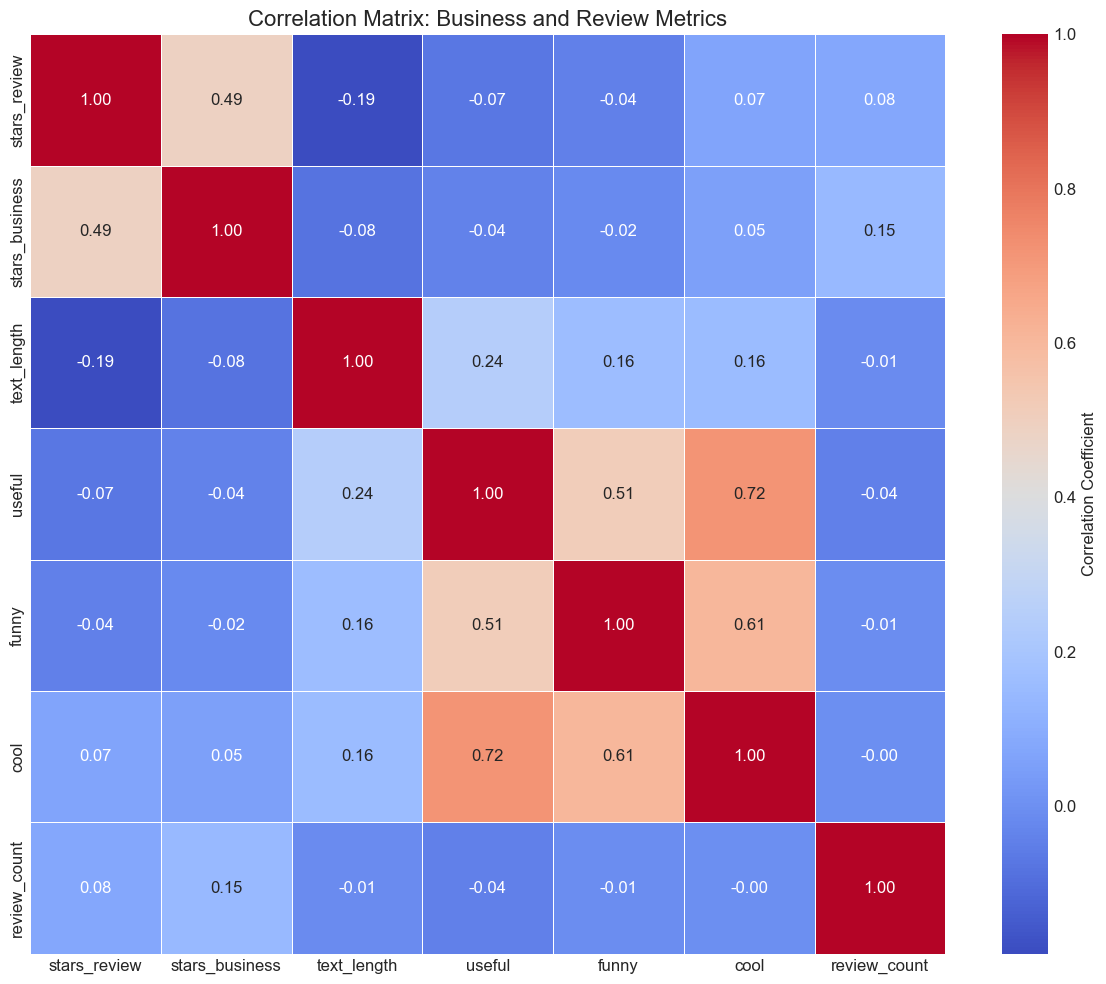

In [ ]:
correlation_data = merged_sample[[
    'stars_review', 'stars_business', 'text_length', 'useful', 'funny', 'cool', 'review_count'
]]

correlation_matrix = correlation_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Matrix: Business and Review Metrics', fontsize=16)
plt.tight_layout()
plt.show()

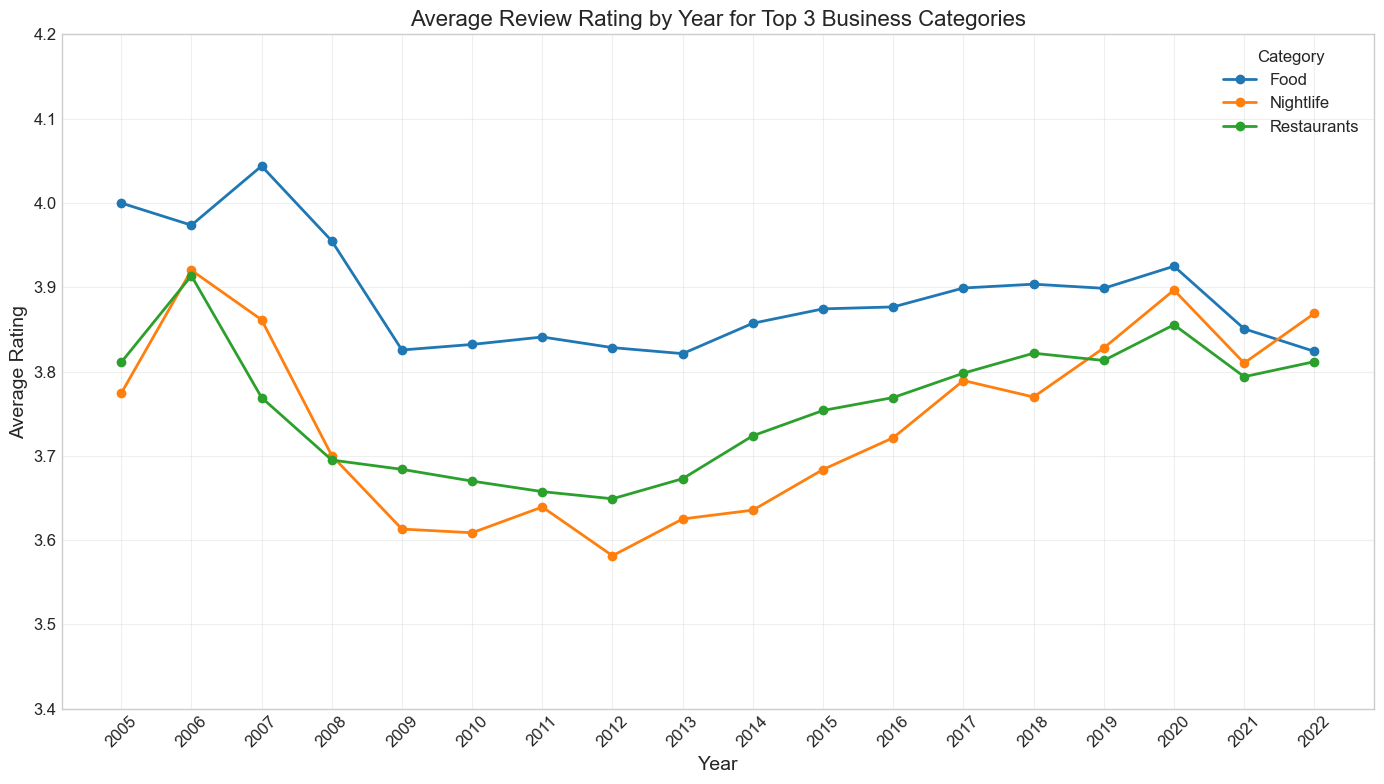

In [ ]:
top_3_categories = merged_sample['primary_category'].value_counts().head(3).index
time_category = merged_sample[merged_sample['primary_category'].isin(top_3_categories)]

ratings_by_year_category = time_category.groupby(['year', 'primary_category'])['stars_review'].mean().reset_index()

ratings_pivot = ratings_by_year_category.pivot(index='year', columns='primary_category', values='stars_review')

plt.figure(figsize=(14, 8))
for category in ratings_pivot.columns:
    plt.plot(ratings_pivot.index, ratings_pivot[category], marker='o', linewidth=2, label=category)

plt.title('Average Review Rating by Year for Top 3 Business Categories', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(ratings_pivot.index, ratings_pivot.index, rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(title='Category')
plt.ylim(3.4, 4.2)  
plt.tight_layout()
plt.show()

In [ ]:
review_counts_by_year_category = time_category.groupby(['year', 'primary_category']).size().reset_index(name='review_count')

review_counts_pivot = review_counts_by_year_category.pivot(index='year', columns='primary_category', values='review_count')

review_counts_pivot = review_counts_pivot.drop([2020,2021,2022], axis=0)

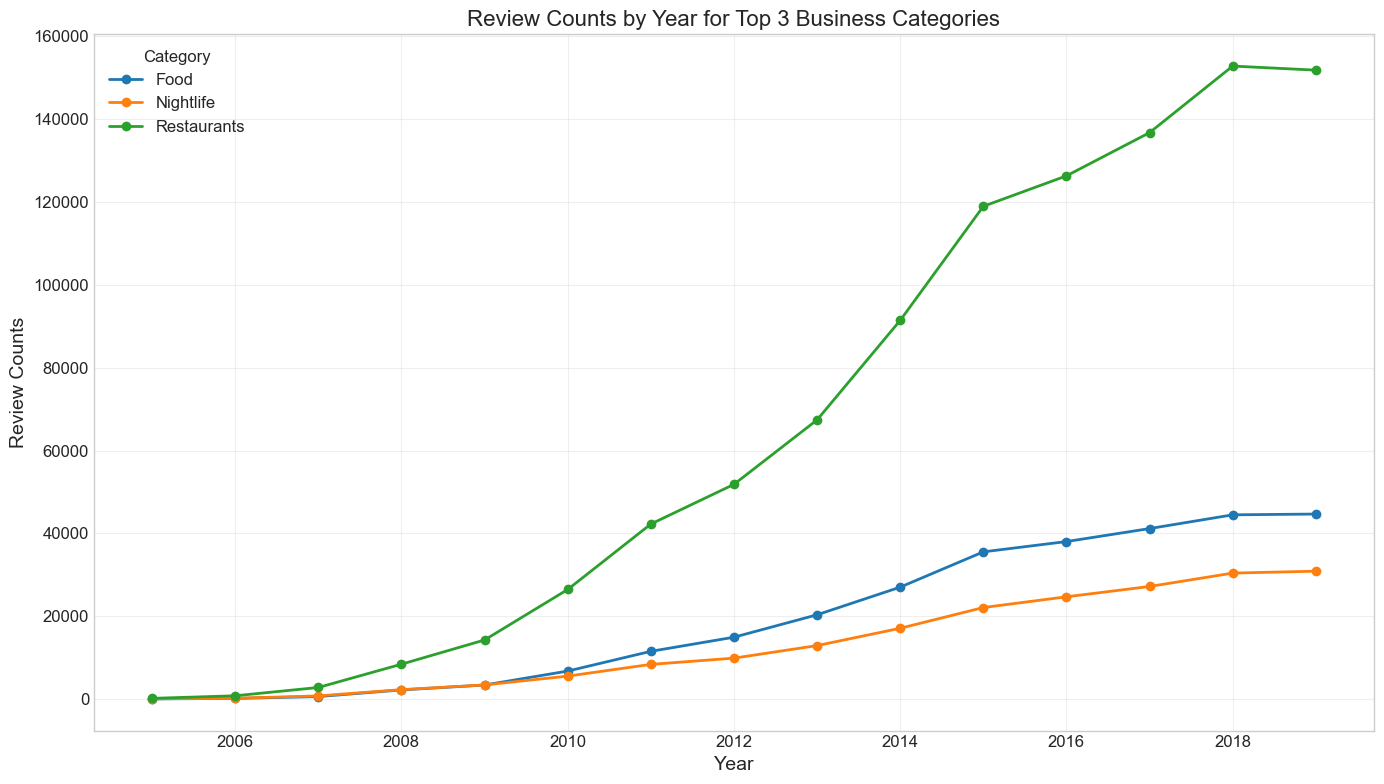

In [ ]:
plt.figure(figsize=(14, 8))
for category in review_counts_pivot.columns:
    plt.plot(review_counts_pivot.index, review_counts_pivot[category], marker='o', linewidth=2, label=category)

plt.title('Review Counts by Year for Top 3 Business Categories', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Review Counts', fontsize=14)

plt.grid(True, alpha=0.3)
plt.legend(title='Category')
plt.tight_layout()
plt.show()


In [ ]:
merged_sample.to_csv('yelp_combined_business_reviews.csv', index=False, encoding='utf-8')

C:\Users\suyog\AppData\Local\Temp\ipykernel_44800\2244052730.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feedback_by_length = engagement_data.groupby('length_bucket')['has_feedback'].mean() * 100
C:\Users\suyog\AppData\Local\Temp\ipykernel_44800\2244052730.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_feedback_by_length = engagement_data.groupby('length_bucket')['total_feedback'].mean()
C:\Users\suyog\AppData\Local\Temp\ipykernel_44800\2244052730.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

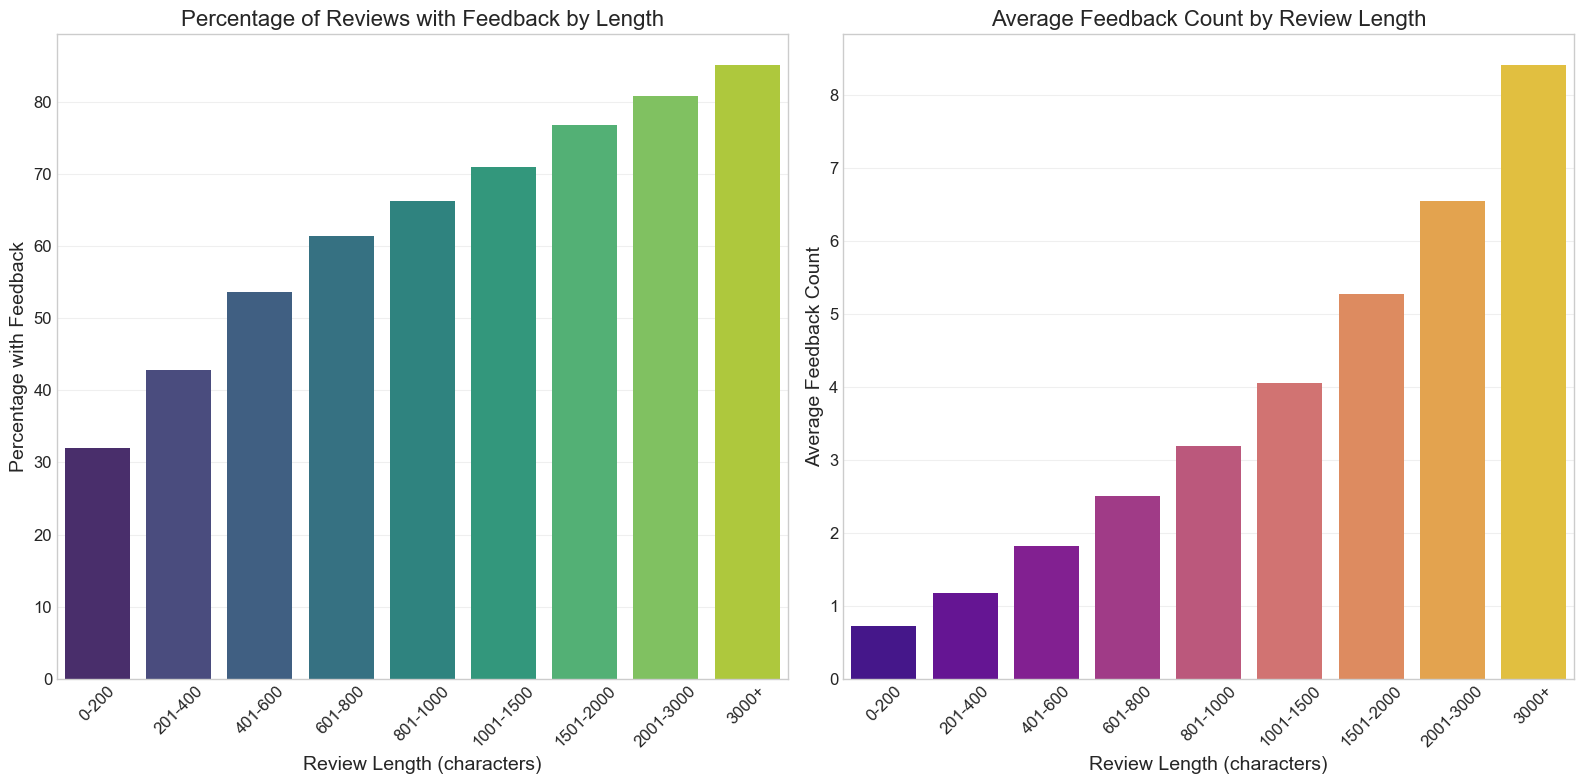

Overall percentage of reviews with feedback: 50.74%
Overall average feedback per review: 2.01


In [ ]:
engagement_data = merged_sample.copy()
engagement_data['has_feedback'] = engagement_data['total_feedback'] > 0


bins = [0, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000]
labels = ['0-200', '201-400', '401-600', '601-800', '801-1000', '1001-1500', '1501-2000', '2001-3000', '3000+']
engagement_data['length_bucket'] = pd.cut(engagement_data['text_length'], bins=bins, labels=labels)


feedback_by_length = engagement_data.groupby('length_bucket')['has_feedback'].mean() * 100
avg_feedback_by_length = engagement_data.groupby('length_bucket')['total_feedback'].mean()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))


sns.barplot(x=feedback_by_length.index, y=feedback_by_length.values, ax=ax1, palette='viridis')
ax1.set_title('Percentage of Reviews with Feedback by Length', fontsize=16)
ax1.set_xlabel('Review Length (characters)', fontsize=14)
ax1.set_ylabel('Percentage with Feedback', fontsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.grid(axis='y', alpha=0.3)


sns.barplot(x=avg_feedback_by_length.index, y=avg_feedback_by_length.values, ax=ax2, palette='plasma')
ax2.set_title('Average Feedback Count by Review Length', fontsize=16)
ax2.set_xlabel('Review Length (characters)', fontsize=14)
ax2.set_ylabel('Average Feedback Count', fontsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Overall percentage of reviews with feedback: {engagement_data['has_feedback'].mean() * 100:.2f}%")
print(f"Overall average feedback per review: {engagement_data['total_feedback'].mean():.2f}")

In [ ]:
def preprocess_text(text):
    
    if not isinstance(text, str):
        return []
    text = text.lower()
    tokens = word_tokenize(text)
    
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word isalpha() and word not in stop_words and len(word) > 2]
    return tokens


topic_sample = df.sample(min(5000, len(merged_sample)), random_state=42)

topic_sample['tokens'] = topic_sample['text'].apply(preprocess_text)

dictionary = Dictionary(topic_sample['tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5)  
corpus = [dictionary.doc2bow(doc) for doc in topic_sample['tokens']]

print(f"Number of unique tokens in dictionary: {len(dictionary)}")
print(f"Number of documents in corpus: {len(corpus)}")

NameError: name 'word_tokenize' is not defined

In [ ]:

num_topics = 10  


lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10
)


print("Top words in each topic:")
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx+1}:")
    print(topic)
    print()

Top words in each topic:
Topic 1:
0.014*"would" + 0.013*"get" + 0.011*"service" + 0.011*"back" + 0.010*"time" + 0.009*"never" + 0.009*"car" + 0.009*"one" + 0.008*"told" + 0.008*"said"

Topic 2:
0.013*"chicken" + 0.011*"delicious" + 0.011*"good" + 0.010*"food" + 0.010*"shrimp" + 0.010*"sauce" + 0.008*"ordered" + 0.007*"fried" + 0.007*"salad" + 0.006*"great"

Topic 3:
0.014*"store" + 0.011*"get" + 0.009*"place" + 0.008*"order" + 0.008*"dog" + 0.007*"find" + 0.007*"people" + 0.007*"make" + 0.007*"time" + 0.007*"like"

Topic 4:
0.011*"like" + 0.010*"one" + 0.010*"good" + 0.010*"food" + 0.009*"ordered" + 0.008*"order" + 0.008*"would" + 0.007*"got" + 0.007*"came" + 0.007*"back"

Topic 5:
0.027*"cake" + 0.020*"chocolate" + 0.012*"cookies" + 0.012*"nail" + 0.011*"cause" + 0.011*"spa" + 0.010*"patients" + 0.010*"hours" + 0.009*"buy" + 0.009*"made"

Topic 6:
0.035*"good" + 0.015*"food" + 0.014*"great" + 0.014*"place" + 0.013*"really" + 0.012*"burger" + 0.011*"cheese" + 0.011*"beer" + 0.010*"like

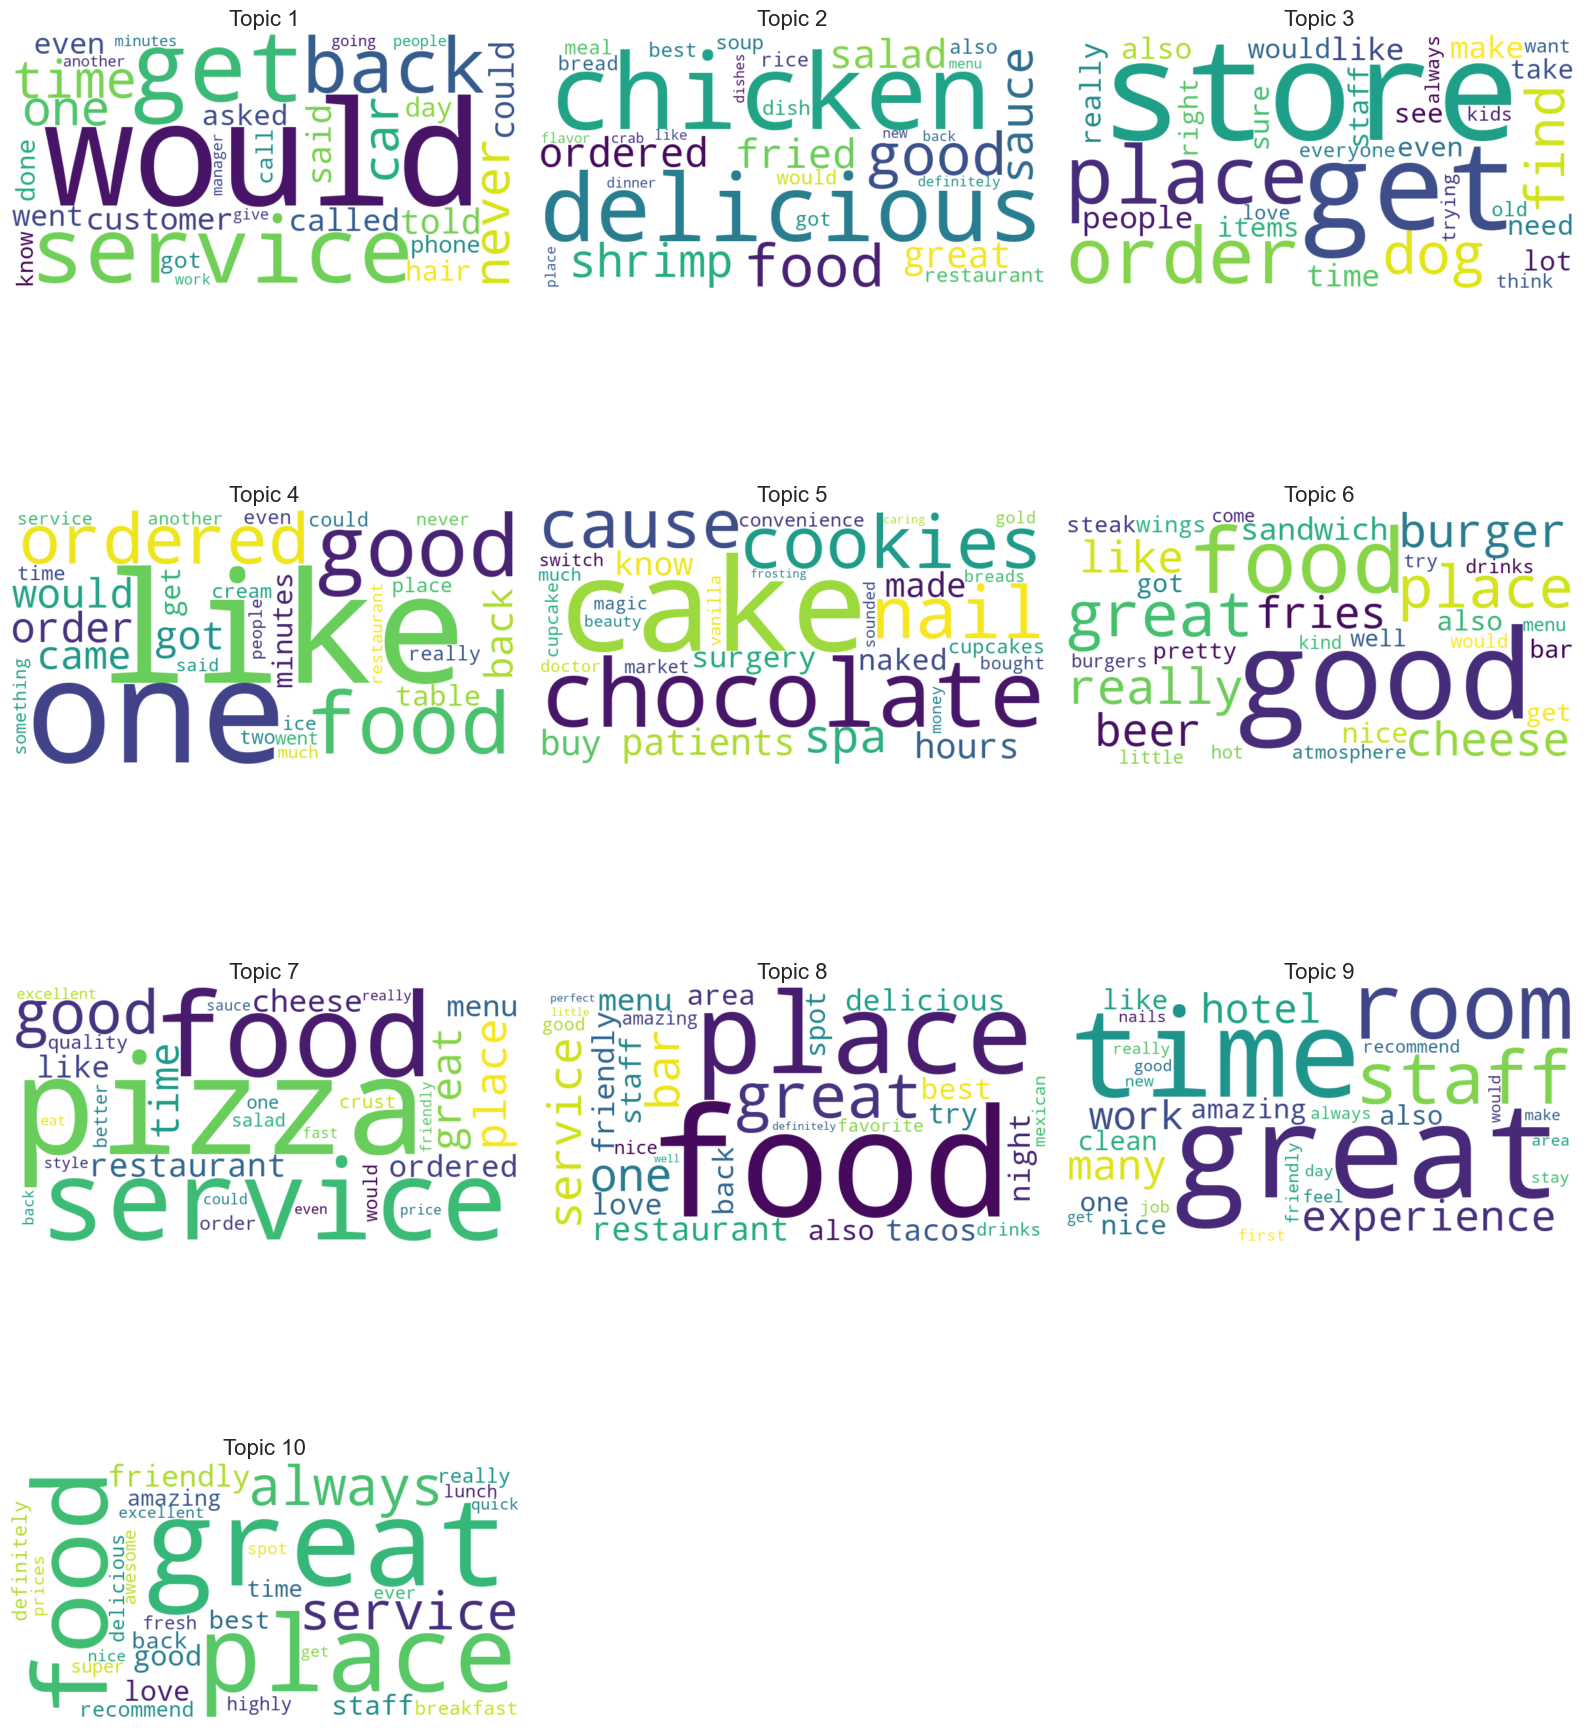

In [ ]:

plt.figure(figsize=(16, 20))

for i in range(num_topics):
    
    topic_words = dict(lda_model.show_topic(i, 30))
    
    
    plt.subplot(4, 3, i+1)
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate_from_frequencies(topic_words)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {i+1}', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()

#

Let's build a simple model to predict business ratings based on various features.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


model_data = merged_sample.groupby('business_id').agg({
    'stars_review': 'mean',
    'text_length': 'mean',
    'useful': 'mean',
    'cool': 'mean',
    'funny': 'mean',
    'stars_business': 'first',  
    'review_count': 'first',
    'primary_category': 'first'
}).reset_index()


top_categories = model_data['primary_category'].value_counts().head(20).index
model_data['is_top_category'] = model_data['primary_category'].isin(top_categories).astype(int)


features = ['stars_review', 'text_length', 'useful', 'cool', 'funny', 'review_count', 'is_top_category']
target = 'stars_business'


model_data = model_data.dropna(subset=features + [target])


X = model_data[features]
y = model_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (120276, 7)
Test data shape: (30070, 7)


In [ ]:

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


lr_pred = lr_model.predict(X_test)


lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_pred)

print("Linear Regression Model Performance:")
print(f"RMSE: {lr_rmse:.4f}")
print(f"R^2: {lr_r2:.4f}")


feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_model.coef_
})
print("\nFeature Coefficients:")
print(feature_importance.sort_values('Coefficient', ascending=False))

Linear Regression Model Performance:
RMSE: 0.1576
R^2: 0.9737

Feature Coefficients:
           Feature  Coefficient
0     stars_review     1.000599
2           useful     0.000706
1      text_length     0.000011
5     review_count    -0.000017
4            funny    -0.000257
3             cool    -0.000283
6  is_top_category    -0.002763


In [ ]:

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


rf_pred = rf_model.predict(X_test)


rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest Model Performance:")
print(f"RMSE: {rf_rmse:.4f}")
print(f"R^2: {rf_r2:.4f}")


feature_importance_rf = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
})
print("\nFeature Importance:")
print(feature_importance_rf.sort_values('Importance', ascending=False))

Random Forest Model Performance:
RMSE: 0.1115
R^2: 0.9869

Feature Importance:
           Feature  Importance
0     stars_review    0.987766
5     review_count    0.003068
1      text_length    0.003030
2           useful    0.002360
3             cool    0.001777
4            funny    0.001680
6  is_top_category    0.000319


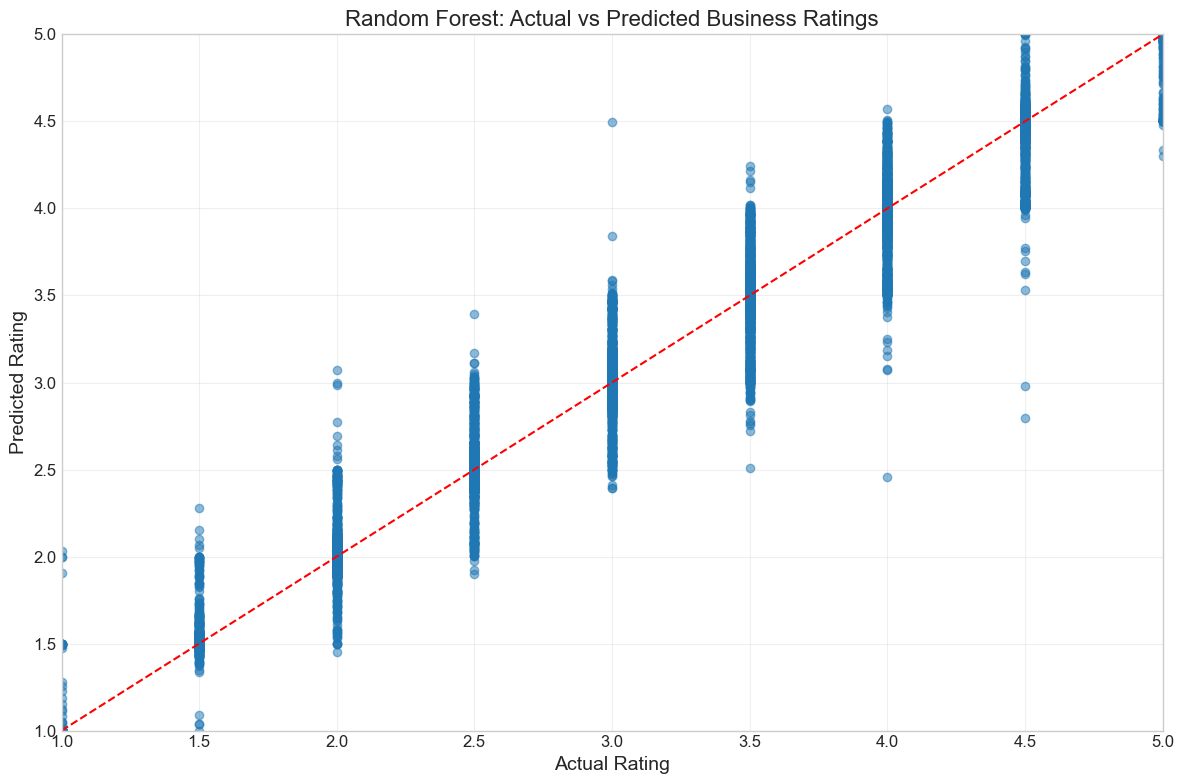

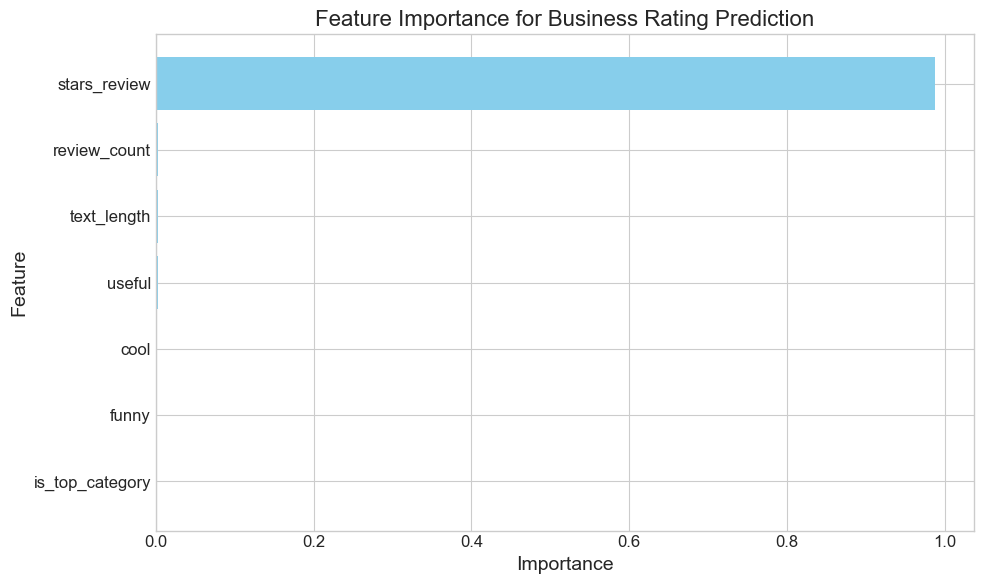

In [ ]:

plt.figure(figsize=(12, 8))


plt.scatter(y_test, rf_pred, alpha=0.5)
plt.plot([1, 5], [1, 5], 'r--')  

plt.title('Random Forest: Actual vs Predicted Business Ratings', fontsize=16)
plt.xlabel('Actual Rating', fontsize=14)
plt.ylabel('Predicted Rating', fontsize=14)
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
feature_importance_rf = feature_importance_rf.sort_values('Importance')
plt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], color='skyblue')
plt.title('Feature Importance for Business Rating Prediction', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

# Testing network analysis

In [ ]:
import networkx as nx


network_sample = merged_sample.sample(min(50000, len(merged_sample)), random_state=42)


G = nx.Graph()


users = set(network_sample['user_id'])
businesses = set(network_sample['business_id'])


for user in users:
    G.add_node(user, type='user')

for business in businesses:
    G.add_node(business, type='business')


for _, row in network_sample.iterrows():
    G.add_edge(row['user_id'], row['business_id'], rating=row['stars_review'])


print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Number of user nodes: {len([n for n, attr in G.nodes(data=True) if attr.get('type') == 'user'])}")
print(f"Number of business nodes: {len([n for n, attr in G.nodes(data=True) if attr.get('type') == 'business'])}")

Number of nodes: 74550
Number of edges: 49977
Number of user nodes: 44905
Number of business nodes: 29645
Number of user nodes: 44905
Number of business nodes: 29645


In [ ]:
degree_centrality = nx.degree_centrality(G)

user_centrality = {node: centrality for node, centrality in degree_centrality.items() 
                  if G.nodes[node]['type'] == 'user'}
top_users = sorted(user_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

business_centrality = {node: centrality for node, centrality in degree_centrality.items() 
                      if G.nodes[node]['type'] == 'business'}
top_businesses = sorted(business_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Most Central Users:")
for user, centrality in top_users:
    user_reviews = len([e for e in G.edges(user)])
    print(f"User: {user}, Centrality: {centrality:.6f}, Reviews: {user_reviews}")

print("\nTop 10 Most Central Businesses:")
for business, centrality in top_businesses:
    business_reviews = len([e for e in G.edges(business)])
    business_name = merged_sample[merged_sample['business_id'] == business]['name'].iloc[0] if business in merged_sample['business_id'].values else 'Unknown'
    print(f"Business: {business_name}, ID: {business}, Centrality: {centrality:.6f}, Reviews: {business_reviews}")

Top 10 Most Central Users:
User: _BcWyKQL16ndpBdggh2kNA, Centrality: 0.000282, Reviews: 21
User: ET8n-r7glWYqZhuR6GcdNw, Centrality: 0.000188, Reviews: 14
User: eTvp_hYnsrI5-ow_sQ31_g, Centrality: 0.000188, Reviews: 14
User: qjfMBIZpQT9DDtw_BWCopQ, Centrality: 0.000161, Reviews: 12
User: cIVmIJD7nIiEcVGamfBoVw, Centrality: 0.000161, Reviews: 12
User: -G7Zkl1wIWBBmD0KRy_sCw, Centrality: 0.000161, Reviews: 12
User: pou3BbKsIozfH50rxmnMew, Centrality: 0.000161, Reviews: 12
User: bJ5FtCtZX3ZZacz2_2PJjA, Centrality: 0.000148, Reviews: 11
User: VL12EhEdT4OWqGq0nIqkzw, Centrality: 0.000148, Reviews: 11
User: -kLVfaJytOJY2-QdQoCcNQ, Centrality: 0.000134, Reviews: 10

Top 10 Most Central Businesses:
Business: Acme Oyster House, ID: _ab50qdWOk0DdB6XOrBitw, Centrality: 0.000872, Reviews: 65
Business: Acme Oyster House, ID: _ab50qdWOk0DdB6XOrBitw, Centrality: 0.000872, Reviews: 65
Business: Oceana Grill, ID: ac1AeYqs8Z4_e2X5M3if2A, Centrality: 0.000738, Reviews: 55
Business: Oceana Grill, ID: ac1A

In [97]:
merged_sample.to_csv('yelp_combined_business_reviews.csv', index=False, encoding='utf-8')

In [ ]:

import pyarrow.parquet as pq
import pyarrow as pa

combined = pq.read_table('yelp_combined_business_reviews.parquet')

pyarrow.Table
review_id: string
user_id: string
business_id: string
stars_review: double
useful: int64
funny: int64
cool: int64
text: string
date: string
text_length: int64
total_feedback: int64
year: int64
month: int64
day_of_week: int64
hour: int64
name: string
city: string
state: string
stars_business: double
review_count: int64
primary_category: string
----
review_id: [["KU_O5udG6zpxOg-VcAEodg","BiTunyQ73aT9WBnpR9DZGw","saUsX_uimxRlCVr67Z4Jig","AqPFMleE6RsU23_auESxiA","Sx8TMOWLNuJBWer-0pcmoA",...,"B1EnNP0LxlQT9_AmM0CqFg","JOLag8-BvNxfP_osIWO98w","R0fnA5zJzfzl2nrlM83Ljg","jHmqmoEI-78BGHFJaDKlhQ","Lgnkn92z4EiohkPbmkIgrg"],["AwGXYvoOumRE3DJEZ7vB0A","jWhFitduqz_A0TLDXEMdeA","mDrKDmm-86wnBnTMqGRP6A","tTSvASgkeyixM1md0wl3CQ","_WDIyDDNzwvlCkVyD8qRyA",...,"kmlQF7YkoFjRQGDCEiHOJA","tWbVu-Lf-diaFPKiLptwyQ","0j4Zb7cafeJW-sUTi98m0A","5sq5qFjY5mrqkEHimZW6Gw","kLIteEj6hlbG4m3f8rdHfw"],...,["uhXSuYz5IiMXYPAxYsaBLw","0-leIbKIRvnmEjs2XCCLyA","FsZl3hBc5p1q67rS-4qa6A","hpAMmnAId_74Z-NKmRIXkA","QqC_7d

In [9]:
combined_df = combined.to_pandas()
combined_df

review_id                 user_id  \
0        KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA   
1        BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q   
2        saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A   
3        AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ   
4        Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ   
...                         ...                     ...   
6990275  H0RIamZu0B0Ei0P4aeh3sQ  qskILQ3k0I_qcCMI-k6_QQ   
6990276  shTPgbgdwTHSuU67mGCmZQ  Zo0th2m8Ez4gLSbHftiQvg   
6990277  YNfNhgZlaaCO5Q_YJR4rEw  mm6E4FbCMwJmb7kPDZ5v2Q   
6990278  i-I4ZOhoX70Nw5H0FwrQUA  YwAMC-jvZ1fvEUum6QkEkw   
6990279  RwcKOdEuLRHNJe4M9-qpqg  6JehEvdoCvZPJ_XIxnzIIw   

                    business_id  stars_review  useful  funny  cool  \
0        XQfwVwDr-v0ZS3_CbbE5Xw           3.0       0      0     0   
1        7ATYjTIgM3jUlt4UM3IypQ           5.0       1      0     1   
2        YjUWPpI6HXG530lwP-fb2A           3.0       0      0     0   
3        kxX2SOes4o-D3ZQBkiMRfA           5.0       1      0     1   
4        e4Vwtrqf-wpJfwesgvdgxQ           4.0       1      0     1   
...                         ...           ...     ...    ...   ...   
6990275  jals67o91gcrD4DC81Vk6w           5.0       1      2     1   
6990276  2vLksaMmSEcGbjI5gywpZA           5.0       2      1     2   
6990277  R1khUUxidqfaJmcpmGd4aw           4.0       1      0     0   
6990278  Rr9kKArrMhSLVE9a53q-aA           5.0       1      0     0   
6990279  VAeEXLbEcI9Emt9KGYq9aA           3.0      10      3     7   

                                                      text  \
0        If you decide to eat here, just be aware it is...   
1        I've taken a lot of spin classes over the year...   
2        Family diner. Had the buffet. Eclectic assortm...   
3        Wow!  Yummy, different,  delicious.   Our favo...   
4        Cute interior and owner (?) gave us tour of up...   
...                                                    ...   
6990275  Latest addition to services from ICCU is Apple...   
6990276  This spot offers a great, affordable east week...   
6990277  This Home Depot won me over when I needed to g...   
6990278  For when I'm feeling like ignoring my calorie-...   
6990279  Located in the 'Walking District' in Nashville...   

                        date  text_length  ...  year  month  day_of_week  \
0        2018-07-07 22:09:11          513  ...  2018      7            5   
1        2012-01-03 15:28:18          829  ...  2012      1            1   
2        2014-02-05 20:30:30          339  ...  2014      2            2   
3        2015-01-04 00:01:03          243  ...  2015      1            6   
4        2017-01-14 20:54:15          534  ...  2017      1            5   
...                      ...          ...  ...   ...    ...          ...   
6990275  2014-12-17 21:45:20          322  ...  2014     12            2   
6990276  2021-03-31 16:55:10          397  ...  2021      3            2   
6990277  2019-12-30 03:56:30          467  ...  2019     12            0   
6990278  2022-01-19 18:59:27         2317  ...  2022      1            2   
6990279  2018-01-02 22:50:47         1198  ...  2018      1            1   

         hour                                name          city state  \
0          22        Turning Point of North Wales   North Wales    PA   
1          15          Body Cycle Spinning Studio  Philadelphia    PA   
2          20                   Kettle Restaurant        Tucson    AZ   
3           0                               Zaika  Philadelphia    PA   
4          20                                Melt   New Orleans    LA   
...       ...                                 ...           ...   ...   
6990275    21          Idaho Central Credit Union         Boise    ID   
6990276    16  Canoe Outpost-Little Manatee River       Wimauma    FL   
6990277     3                      The Home Depot  Willow Grove    PA   
6990278    18                   Sauce on the Side  Indianapolis    IN   
6990279    

## Data Cleaning and Preprocessing

Let's clean and preprocess our combined dataset before performing further analysis.

In [ ]:
clean_df = combined_df.copy()


In [15]:
# Comprehensive data cleaning for the combined DataFrame
import numpy as np
import pandas as pd
from datetime import datetime

# Make a copy to avoid modifying the original dataframe

# 1. Fix data types
# Convert date string to datetime
clean_df['date'] = pd.to_datetime(clean_df['date'])

# 2. Handle missing values
print(f"Missing values before cleaning:\n{clean_df.isnull().sum()}")

# Fill missing primary category values
clean_df['primary_category'] = clean_df['primary_category'].fillna('Uncategorized')

# Fill missing review_count with median value
median_review_count = clean_df['review_count'].median()
clean_df['review_count'] = clean_df['review_count'].fillna(median_review_count)

# Fill missing business star ratings with the mean of review ratings for that business
business_avg_stars = clean_df.groupby('business_id')['stars_review'].mean()
for business_id in clean_df[clean_df['stars_business'].isna()]['business_id'].unique():
    if business_id in business_avg_stars.index:
        clean_df.loc[clean_df['business_id'] == business_id, 'stars_business'] = business_avg_stars[business_id]

# Fill any remaining missing star ratings with the overall median
clean_df['stars_business'] = clean_df['stars_business'].fillna(clean_df['stars_business'].median())

# 3. Remove duplicate reviews
review_count_before = len(clean_df)
clean_df = clean_df.drop_duplicates(subset=['review_id'])
print(f"Removed {review_count_before - len(clean_df)} duplicate reviews")

# 4. Fix and standardize text (handle nulls and empty strings)
clean_df['text'] = clean_df['text'].fillna('')
clean_df['text_length'] = clean_df['text'].apply(len)

# 5. Standardize city and state names
# Convert city and state names to title case
clean_df['city'] = clean_df['city'].str.title()
clean_df['state'] = clean_df['state'].str.upper()

# 6. Handle outliers in numeric columns
# Cap extremely high values for text_length
text_length_percentile_99 = clean_df['text_length'].quantile(0.99)
clean_df['text_length_original'] = clean_df['text_length']  # preserve original values
clean_df['text_length_capped'] = clean_df['text_length'].clip(upper=text_length_percentile_99)

# Cap extremely high values for feedback counts
for col in ['useful', 'funny', 'cool', 'total_feedback']:
    percentile_99 = clean_df[col].quantile(0.99)
    clean_df[f'{col}_original'] = clean_df[col]  # preserve original values
    clean_df[f'{col}_capped'] = clean_df[col].clip(upper=percentile_99)

# 7. Calculate derived features for analysis
# Add month and day names
clean_df['month_name'] = clean_df['date'].dt.strftime('%B')
clean_df['day_name'] = clean_df['date'].dt.strftime('%A')

# Add time of day category
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

clean_df['time_of_day'] = clean_df['hour'].apply(categorize_time)

# 8. Flag users with unusual activity (potential spam or power users)
user_review_counts = clean_df.groupby('user_id')['review_id'].count()
user_review_count_percentile_95 = user_review_counts.quantile(0.95)
high_volume_users = set(user_review_counts[user_review_counts > user_review_count_percentile_95].index)
clean_df['is_power_user'] = clean_df['user_id'].isin(high_volume_users)

# 9. Flag businesses with unusual review patterns
business_review_counts = clean_df.groupby('business_id')['review_id'].count()
business_review_count_percentile_95 = business_review_counts.quantile(0.95)
high_review_businesses = set(business_review_counts[business_review_counts > business_review_count_percentile_95].index)
clean_df['is_popular_business'] = clean_df['business_id'].isin(high_review_businesses)

# 10. Final check and report on the cleaning
print(f"\nMissing values after cleaning:\n{clean_df.isnull().sum()}")
print(f"\nShape after cleaning: {clean_df.shape}")
print(f"\nData types after cleaning:\n{clean_df.dtypes}")

# Display a sample of the cleaned data
clean_df.sample(5)

Missing values before cleaning:
review_id           0
user_id             0
business_id         0
stars_review        0
useful              0
funny               0
cool                0
text                0
date                0
text_length         0
total_feedback      0
year                0
month               0
day_of_week         0
hour                0
name                0
city                0
state               0
stars_business      0
review_count        0
primary_category    0
dtype: int64


MemoryError: Unable to allocate 53.3 MiB for an array with shape (1, 6990280) and data type int64

In [16]:
# Summary statistics for the cleaned dataset
# Numeric columns
numeric_summary = clean_df.describe()
print("Summary of numeric columns:")
display(numeric_summary)

# Categorical columns
categorical_columns = ['city', 'state', 'primary_category', 'month_name', 'day_name', 'time_of_day']
for col in categorical_columns:
    print(f"\nTop values for {col}:")
    print(clean_df[col].value_counts().head(10))

# Distribution of reviews by state (top 10)
plt.figure(figsize=(12, 6))
state_counts = clean_df['state'].value_counts().head(10)
sns.barplot(x=state_counts.index, y=state_counts.values)
plt.title('Number of Reviews by State (Top 10)', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Save the cleaned dataset
clean_df.to_parquet('yelp_clean_dataset.parquet', index=False)

MemoryError: Unable to allocate 480. MiB for an array with shape (9, 6990280) and data type int64

In [ ]:
# Distribution of ratings by category (top 10 categories)
top10_categories = clean_df['primary_category'].value_counts().head(10).index
category_ratings = clean_df[clean_df['primary_category'].isin(top10_categories)]

plt.figure(figsize=(14, 8))
sns.boxplot(x='primary_category', y='stars_review', data=category_ratings)
plt.title('Distribution of Ratings by Top Categories', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Rating', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Check for rating bias - how do ratings differ across years?
yearly_avg_rating = clean_df.groupby('year')['stars_review'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='stars_review', data=yearly_avg_rating, marker='o')
plt.title('Average Star Rating by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()